---
title: "Building a Hierarchical Model For Estimating Covid-19 Excess Mortality"
description: "Using a hierarchical Bayesian model to analyze and compare excess mortality due to Covid-19 in the German states."
date: "2023-03-01"
image: "image.png"
format:
  html:
    code-fold: true
    code-line-numbers: false
jupyter: python3
---

For grouped data, Bayesian modeling offers three basic techniques: pooled models that assume no distinction between groups (i.e., *pooling* all information), unpooled models that assume a complete distinction between groups (i.e., considering all groups separately), and partially pooled (or hierarchical) models which allow each group to have its own model but also assume that groups can provide information about another. In this blog post, we'll build a hierarchical model for estimating excess mortality in the German states. For the probabilistic programming part, we'll use [PyMC](https://www.pymc.io/welcome.html).

In [110]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as patches
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import MultipleLocator, FuncFormatter
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import seaborn as sns
import calendar
from datetime import timedelta

import pymc as pm
import pymc.sampling_jax
import arviz as az
import xarray as xr
import pytensor.tensor as at
from patsy import dmatrix
from sklearn.preprocessing import StandardScaler

from pathlib import Path
import pickle

In [67]:
def create_datasets(df):
    df = df[df.year >= 2010]

    pre_df = df[df["is_pre_covid"]].copy().reset_index(drop=True)
    post_df = df[~df["is_pre_covid"]].copy().reset_index(drop=True)

    for feature in ["mean_temp", 
                    "flu_cases_per100k",
                    "flu_cases_per100k_lag1",
                    "flu_cases_75_79_per100k", 
                    "flu_cases_75_79_per100k_lag1",
                    "flu_cases_75_79_per100k_lag2",
                    "flu_cases_gt80_per100k", 
                    "flu_cases_gt80_per100k_lag1",
                    "flu_cases_gt80_per100k_lag2",
                    "flu_last_year", 
                    "disease_cases_per100k",
                    "disease_cases_per100k_lag1",
                    "disease_cases_75_79_per100k", 
                    "disease_cases_75_79_per100k_lag1",
                    "disease_cases_75_79_per100k_lag2",
                    "disease_cases_gt80_per100k", 
                    "disease_cases_gt80_per100k_lag1",
                    "disease_cases_gt80_per100k_lag2",
                    "disease_last_year"]:
        ss = StandardScaler()
        ss.fit(pre_df[feature].values.reshape(-1, 1))
        pre_df[f"{feature}_st"] = ss.transform(pre_df[feature].values.reshape(-1, 1)).ravel()
        post_df[f"{feature}_st"] = ss.transform(post_df[feature].values.reshape(-1, 1)).ravel()

    return pre_df, post_df

def get_plot(figsize=(11, 4), title=None, xlabel=None, ylabel=None):
    _, ax = plt.subplots(figsize=figsize)
    ax.grid(axis="y", which="major", color="#e6e5e3", zorder=1)
    ax.tick_params(axis="both", labelsize=9)
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)
    for spine in ["bottom", "left"]:
        ax.spines[spine].set_linewidth(1.1)
    if title is not None:
        ax.set_title(title, fontsize=12)
    if xlabel is not None:
        ax.set_xlabel(xlabel, fontsize=10)
    if ylabel is not None:
        ax.set_ylabel(ylabel, fontsize=10)

    return ax

In [65]:
data_path = Path("../data/final/germany.ftr")
df = pd.read_feather(data_path)
pre_df, post_df = create_datasets(df.copy())

## The Problem

In Germany it has been a matter of fierce debate whether patients whose deaths were officially reported as being "associated with Covid-19" have died *due to* or *with* Covid-19. Providing a reliable answer to this question boils down to estimating excess mortality. The total number of recorded deaths is not only readily available but also unaffected by the (quite contentious) definition of Covid-19 deaths, and can therefore serve as an objective metric. 

It turns out that the common approach is to compare weekly mortality numbers of the year in question with the median of some reference years. The [Federal Statistical Office of Germany (destatis)](https://www.destatis.de/DE/Home/_inhalt.html), for example, estimates excess mortality by comparing weekly deaths of a given year with the weekly median of the four previous years, yielding figures like the one that I recreated below for the year 2022 (see [here](https://www.destatis.de/DE/Themen/Gesellschaft-Umwelt/Bevoelkerung/Sterbefaelle-Lebenserwartung/sterbefallzahlen.html) for the analysis by destatis). 

In [70]:
def plot_compare_past(df, year):
    df_year = df[df.year == year][["week", "deaths_total", "covid_deaths"]]
    df_past = df[df.year.isin(range(year - 4, year))].groupby("week").deaths_total.agg(["min", "median", "max"]).reset_index()
    if df_year.shape[0] > df_past.shape[0]:
        week53 = pd.DataFrame(df_past.iloc[0]).T
        week53["week"] = 53
        df_past = pd.concat([df_past, week53])
    elif df_year.shape[0] < df_past.shape[0]:
        df_past = df_past.iloc[:-1]
    
    _, ax = plt.subplots(figsize=(10, 3))
    ax.plot(df_year.week, df_year.deaths_total, color="#ec4c62", zorder=5, label=f"{year}")
    if year > 2019:
        ax.plot(df_year.week, df_year.covid_deaths, color="#ec4c62", marker="o", markersize=3, label=f"{year} Covid-19")
    ax.plot(df_past.week, df_past["median"], color="#005890", lw=.75, zorder=4, label=f"{year-4}-{year-1} median")
    ax.fill_between(df_past.week, df_past["min"], df_past["max"], color="#acddfd", alpha=0.75, zorder=3, label=f"{year-4}-{year-1} min/max")

    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)
    for spine in ["left", "bottom"]:
        ax.spines[spine].set_linewidth(0.5)

    ax.set_xlabel("calendar week", fontsize=9.5)
    ax.set_ylabel("weekly\ndeaths", rotation="horizontal", labelpad=25, fontsize=9.5)
    ax.set_xlim((0.5, df_past.shape[0] + 0.5))
    ax.set_ylim((0, 34_000))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.yaxis.set_major_locator(MultipleLocator(5_000))
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: format(int(x), ',')))
    ax.tick_params(axis="x", which="minor", labelbottom=False)
    ax.tick_params(axis="x", which="major", labelsize=9)
    ax.tick_params(axis="y", which="major", left=False, labelsize=9, pad=5)
    ax.yaxis.grid(True, which="major", color="#e6e6e6", zorder=-10)
    ax.legend(loc="upper center", prop={"size": 8}, facecolor="white", edgecolor="white")

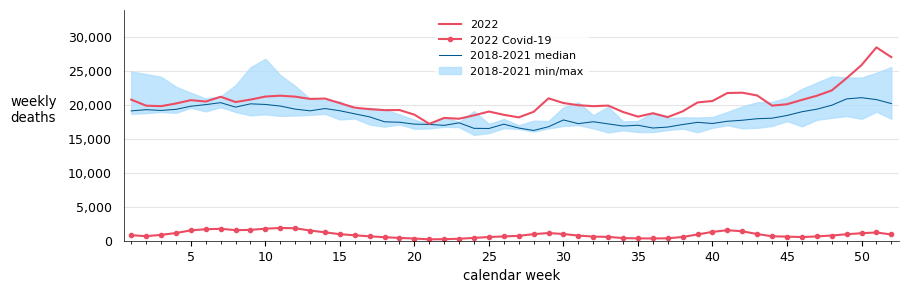

In [71]:
plot_compare_past(df, 2022)

While this approach can certainly help detect major patterns in mortality during the course of a year, there are two drawbacks worth considering:

1. The comparison solely depends on the mortality in the reference years which leads to arbitrary weekly patterns and limited comparability across a broader timeframe and across countries. When it comes to estimating excess mortality due to Covid-19, the approach will fail at the latest when the reference years have already been impacted by Covid-19.
2. By design the method doesn't consider the influence of other factors which are known to impact mortality rates. For instance, not taking the aging of Germany's population into account will inevitably lead to an overestimation of excess mortality (the aging is only partly offset by an increase in life expectancy). There are papers which tried to mitigate this by extrapolating from the reference years (e.g., see [here](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0255540) and [here](https://www.ifo.de/DocDL/ifoDD_22-01_29-35_Ragnitz.pdf)), but they still neglect other important effects. 

So can we build a model explicitly for estimating Covid-19 excess mortality? Before we get into the specifics, it is essential to establish a precise understanding of what we actually mean by "Covid-19 excess mortality". Excess deaths due to Covid-19 are deaths that would not have occurred if Covid-19 had not appeared. Expressed mathematically, excess deaths are the difference between actual deaths and expected deaths.

But since *expected* deaths are an unmeasurable quantity this appears to be simpler than it actually is. The crucial question now is: How many deaths should we *expect*? Or, more precisely and with our specific problem in mind: How many deaths should we expect in a counterfactual scenario with no pandemic? To see the point, let's pause and think only about the role of seasonal influenza. The severity of the yearly influenza wave depends on many factors and is therefore very hard to predict. In some years (e.g., 2014) the wave is mild, while in other years (e.g., 2018) the death toll is very high. Intuitively, one would probably assert that influenza led to no or very few excess deaths in 2014, while the severe wave of 2018 led to significant excess mortality. So how many deaths should we expect for, say, 2021? Following the intuition that we just developed, our expectation *should depend on the severity of the flu wave* in 2021. Thus, given that Covid-19 mitigation measures like mask mandates and social distancing had the side effect of virtually no flu cases, we shouldn't expect any influenza-related deaths. This brings us back to the problems of the baseline approach outlined earlier. If we compared 2021 with the median of the four previous years, the estimated excess deaths would be heavily biased by the flu activity in these years. (The same logic applies to other factors like temperature, of course.) Indeed, a 2022 [study](https://onlinelibrary.wiley.com/doi/10.1111/padr.12475) found that the choice of baseline years is highly influential for the resulting estimate of excess deaths. In Germany, using the four previous years as a baseline [would lead to a significant undercount](https://www.demogr.mpg.de/en/news_events_6123/news_press_releases_4630/news/how_to_calculate_excess_mortality_to_better_estimate_the_impact_of_the_pandemic_10474) of Covid-19 deaths.

Thus, what we'll do instead is build a model that is trained on data before the spread of Covid-19 and capable of accurately predicting weekly mortality figures. We'll use this model to create a counterfactual forecast of mortality for the years impacted by Covid-19 which we will then compare with the number of deaths that were actually reported. Naturally, this approach still has limitations (which are exacerbated by data availability issues); in particular, the number of excess deaths will not only include deaths that were directly caused by the virus, but also deaths that were caused indirectly (e.g., due to worse access to health care) or even indirectly prevented (e.g., less traffic accidents during lockdowns). We should keep this in mind when analyzing our results later.

## The Data

I could gather the following weekly data which I have already cleaned, aggregated and split into `pre_df` (covering the years 2005-2019, not affected by Covid-19) and `post_df` (since 2020, affected by the spread of Covid-19):

* The weekly number of deaths from destatis ([2000-2015](https://www.destatis.de/DE/Themen/Gesellschaft-Umwelt/Bevoelkerung/Sterbefaelle-Lebenserwartung/Tabellen/sonderauswertung-sterbefaelle-endgueltige-daten.html), [2016-2022](https://www.destatis.de/DE/Themen/Gesellschaft-Umwelt/Bevoelkerung/Sterbefaelle-Lebenserwartung/Tabellen/sonderauswertung-sterbefaelle.html))
* Population data from destatis ([1970-2021](https://www-genesis.destatis.de/genesis//online?operation=table&code=12411-0005&bypass=true&levelindex=0&levelid=1670263168957), extrapolated to 2022)
* The average weekly minimum, mean, and maximum temperatures from official weather stations operated by the German Meteorological Service (DWD) ([-2021](https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/daily/kl/historical/), [2022-](https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/daily/kl/recent/))
* Disease data (cases numbers for influenza and other viral or bacterial diseases) from the Robert Koch Institute (RKI), Germany's government agency for disease control and prevention ([2005-2022](https://survstat.rki.de/Content/Query/Create.aspx))
* Data related to Covid-19 from the RKI ([2020-](https://github.com/robert-koch-institut))

Let's have a quick look at the aggregate data for Germany:

### Reported deaths

When we plot the weekly deaths per 100,000 people since the year 2010, we immediately notice two things: the number of deaths increases over the years and there is marked seasonality. Meanwhile it is quite hard to see (at least at first glance) whether the years 2020-2022 really are exceptional.

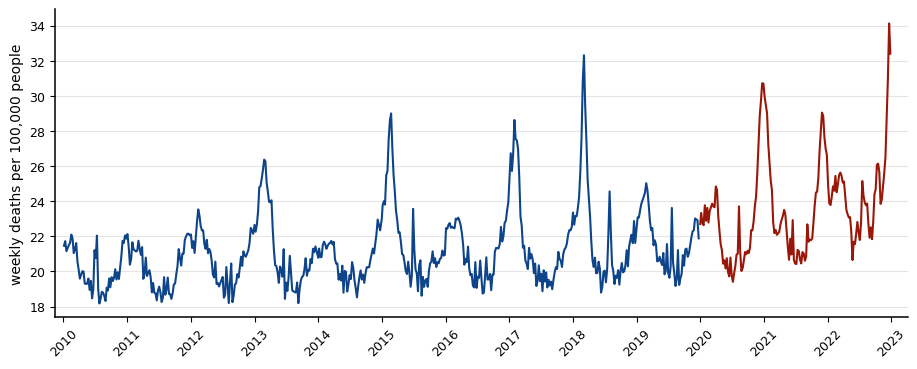

In [72]:
#| code-fold: true

ax = get_plot(ylabel="weekly deaths per 100,000 people")
ax.plot(pre_df.date, pre_df.deaths_per100k, color="#0e448a", zorder=2)
ax.plot(post_df.date, post_df.deaths_per100k, color="#991608", zorder=2)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.set_xlim([pre_df.date.min() - timedelta(days=50), post_df.date.max() + timedelta(days=100)])
ax.tick_params(axis="x", which="both", rotation=45);

### Seasonality

Let's have a closer look at the seasonality. To get a better grasp of the seasonal patterns, we can plot the number of deaths for all years in `pre_df` by calendar week. 

A lot of the seasonality that we can see here has probably to do with temperature effects. As even moderately cold temperatures are known to worsen pre-existing medical conditions like cardiovascular and respiratory diseases, it is not surprising that more deaths are recorded in winter. However, the peaks in summer show that heat waves take their toll too. 

The high mortality in February/March reflects the peaks of flu season. Apart from that the seasonality surely involves other effects that are more loosely related to temperature (e.g., seasonal activities or traffic conditions that are associated with higher mortality). 

Finally note that the color-coding of the years highlights the rise in mortality over the years once more.

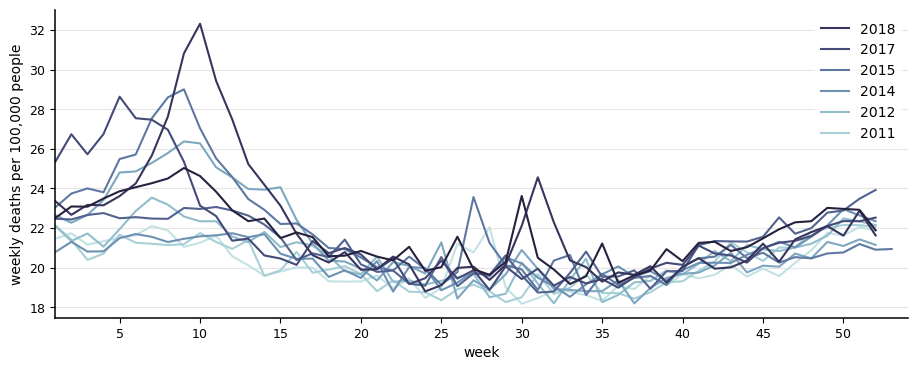

In [73]:
#| code-fold: true

ax = get_plot(ylabel="weekly deaths per 100,000 people")
sns.lineplot(data=pre_df, 
             x="week", 
             y="deaths_per100k", 
             hue="year", 
             palette=sns.cubehelix_palette(start=.2, rot=-.3, as_cmap=True))
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.set_xlim(1, 54)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[::-1], 
          labels=labels[::-1], 
          facecolor="white", 
          edgecolor="white");

### Temperature

The relationship between the number of deaths and mean temperature is quite clear. While moderate temperatures are associated with the lowest mortality, colder temperatures and excessive heat increase the number of deaths.

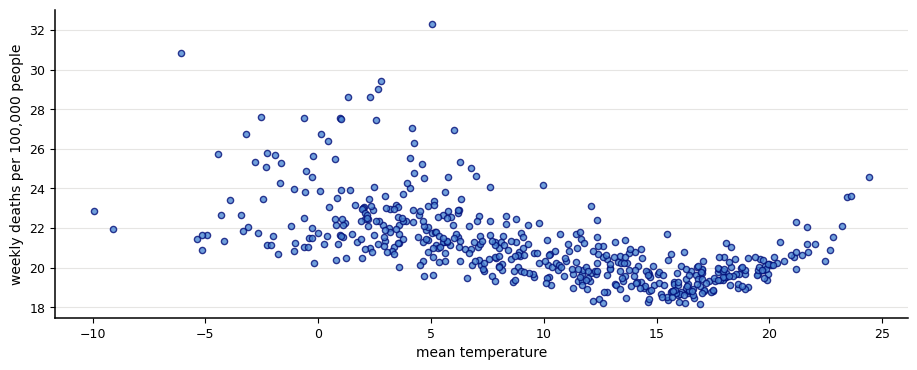

In [74]:
#| code-fold: true

ax = get_plot(xlabel="mean temperature", ylabel="weekly deaths per 100,000 people")
ax.scatter(pre_df.mean_temp, pre_df.deaths_per100k, color="#4c88d4", edgecolor="#020e78", alpha=0.8, s=20, zorder=2);

### Influenza

Finally, let's have a look at influenza. We can plot the number of flu cases (here only the age groups 75-79 and 80+) against the number of weekly deaths:

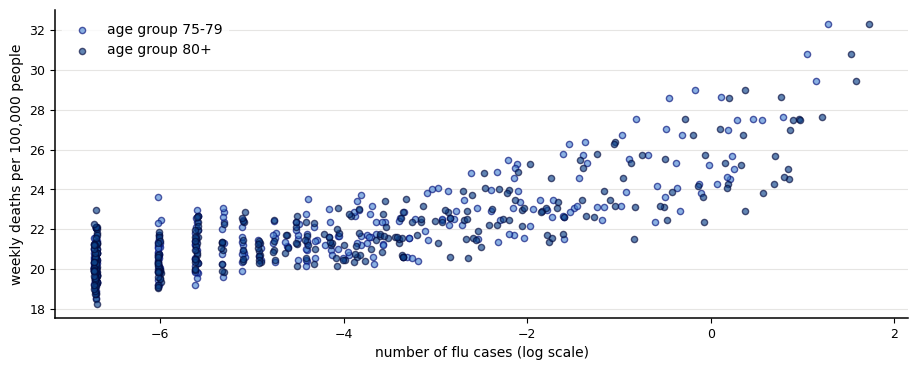

In [75]:
#| code-fold: true

ax = get_plot(xlabel="number of flu cases (log scale)", ylabel="weekly deaths per 100,000 people")
ax.scatter(np.log(pre_df[pre_df.flu_cases > 0].flu_cases_75_79_per100k), pre_df[pre_df.flu_cases > 0].deaths_per100k, color="#4c88d4", edgecolor="#020e78", alpha=0.65, s=20, zorder=2, label="age group 75-79");
ax.scatter(np.log(pre_df[pre_df.flu_cases > 0].flu_cases_gt80_per100k), pre_df[pre_df.flu_cases > 0].deaths_per100k, color="#0e448a", edgecolor="#03093b", alpha=0.65, s=20, zorder=2, label="age group 80+");
ax.legend(facecolor="white", edgecolor="white");

As we can see, the case numbers will likely be useful predictors. Also, note that influenza is highly seasonal and there were very few cases in the years affected by Covid-19:

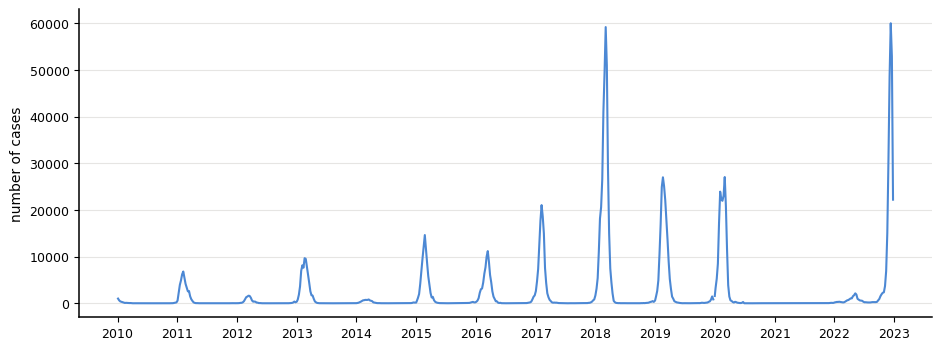

In [76]:
#| code-fold: true

ax = get_plot(ylabel="number of cases")
ax.plot(pre_df[pre_df.flu_cases > 0].date, pre_df[pre_df.flu_cases > 0].flu_cases, color="#4c88d4", zorder=2)
ax.plot(post_df[post_df.flu_cases > 0].date, post_df[post_df.flu_cases > 0].flu_cases, color="#4c88d4", zorder=2)
ax.xaxis.set_major_locator(mdates.YearLocator());

## The Base Model

As advertised, we'll tackle our problem with a Bayesian model (in particular, a Bayesian linear regression model) specified with PyMC. Using a Bayesian model comes with two great advantages: A natural and principled way to incorporate prior knowledge and an intuitive way to quantify uncertainty with probabilities. 

We'll begin with a model for Germany. I'll spare the reader from the iterative process that ultimately resulted in the model presented below, but let's go over the main modeling and feature selection choices:

- To model the seasonality we use PyMC's nifty [`ZeroSumNormal` distribution](https://www.pymc.io/projects/docs/en/stable/api/distributions/generated/pymc.ZeroSumNormal.html) for monthly effects (`month_mu`). This means that the monthly effects will sum to zero improving both parameter identifiability and interpretability.
- The effect of mean temperature (`temp`) on mortality is modeled using splines. We've already seen why this should improve model performance when we plotted mean temperature against weekly deaths. See [here](https://www.pymc.io/projects/examples/en/latest/case_studies/spline.html) and [here](https://bayesiancomputationbook.com/markdown/chp_05.html) for great resources on splines. 
- A little research (e.g., this [paper](https://bmcpublichealth.biomedcentral.com/articles/10.1186/s12889-016-3031-z)) showed that while heat waves affect mortality quite immediately, the effect of cold temperatures can have a considerable lag. For this reason we add two dummy variables that indicate whether the average minimum temperature of the last and second last week was below 0 degrees Celsius (`temp_lag1` and `temp_lag2`).
- To factor in the age of the German population we include the population share of the age groups 70-74, 75-79, and 80+ (`age_70`, `age_75`, and `age_80`). We center these features for better interpretability.
- The last main block of features concerns the role of influenza/other diseases. While we use the number of cases in the age groups 75-79 and 80+ of the previous week for influenza (`flu_7579_lag1`, `flu_gt80_lag1`), we use the case numbers of the current week for the generic category of other viral or bacterial diseases (`disease_7579`, `disease_gt80`). (These features are all standardized for easier interpretability.) For both categories we also include the number of cases reported in the last year (`[flu/disease]_last_year`) since population-level immunity obtained in a given year [tends to dampen the severity of next year's wave](https://www.rki.de/SharedDocs/FAQ/Influenza/FAQ_Liste.html).
- Finally, we include some interactions that should further improve the model: `temp:flu`, `flu:disease`, and `disease:age_80` (where `flu`/`disease` represent the weekly number of cases per 100,000 people for each category).

Specifying this model with reasonable priors in PyMC is fairly straightforward. Note that we wrap the model building in a factory function to make our life a lot [easier](https://discourse.pymc.io/t/unable-to-predict-using-set-value-with-an-errors-in-variables-model/5236/5) when we compute the counterfactual forecast for the years affected by Covid-19.

In [77]:
#| code-fold: show

def create_model(pre_df, post_df, infer_post=False):

    df = pre_df if not infer_post else post_df

    knot_list = np.quantile(pre_df.mean_temp, np.linspace(0, 1, 5))
    B = dmatrix("0 + bs(mean_temp, knots=knots, degree=2, include_intercept=True)",
                {"mean_temp": df.mean_temp.values, "knots": knot_list[1:-1]})

    coords = {
        "month": calendar.month_name[1:],
        "splines": np.arange(B.shape[1])
    }

    with pm.Model(coords=coords) as model:

        # observed data
        month = pm.MutableData("month", df["month"].to_numpy(), dims="obs_id")
        temp = pm.MutableData("temp", df["mean_temp_st"].to_numpy(), dims="obs_id")
        temp_lag1 = pm.MutableData("temp lag1", df["min_lt0_lag1"].to_numpy(), dims="obs_id")
        temp_lag2 = pm.MutableData("temp lag2", df["min_lt0_lag2"].to_numpy(), dims="obs_id")
        age_70 = pm.MutableData("age 70-75", df["pop_share_70_74_cnt"].to_numpy(), dims="obs_id")
        age_75 = pm.MutableData("age 75-80", df["pop_share_75_79_cnt"].to_numpy(), dims="obs_id")
        age_80 = pm.MutableData("age 80+", df["pop_share_gt80_cnt"].to_numpy(), dims="obs_id")
        flu = pm.MutableData("flu cases per 100k", df["flu_cases_per100k_st"].to_numpy(), dims="obs_id")
        flu_75_lag1 = pm.MutableData("flu cases age 75-79 per 100k lag1", df["flu_cases_75_79_per100k_lag1_st"].to_numpy(), dims="obs_id")
        flu_80_lag1 = pm.MutableData("flu cases age 80+ per 100k lag1", df["flu_cases_gt80_per100k_lag1_st"].to_numpy(), dims="obs_id")
        flu_last_year = pm.MutableData("flu cases last year", df["flu_last_year_st"].to_numpy(), dims="obs_id")
        disease = pm.MutableData("disease cases per 100k", df["disease_cases_per100k_st"].to_numpy(), dims="obs_id")
        disease_75 = pm.MutableData("disease cases age 75-79 per 100k", df["disease_cases_75_79_per100k_st"].to_numpy(), dims="obs_id")
        disease_80 = pm.MutableData("disease cases age 80+ per 100k", df["disease_cases_gt80_per100k_st"].to_numpy(), dims="obs_id")
        disease_last_year = pm.MutableData("disease last year", df["disease_last_year_st"].to_numpy(), dims="obs_id")
        deaths = pm.MutableData("deaths per 100k", df["deaths_per100k"].to_numpy(), dims="obs_id")

        # priors
        intercept = pm.Normal("intercept", mu=20, sigma=1)
        month_mu = pm.ZeroSumNormal("month mu", sigma=2, dims="month")
        w = pm.Normal("w", mu=0, sigma=3, size=B.shape[1], dims="splines")
        temp_lag1_coeff = pm.Normal("temp lag1 coeff", mu=0.5, sigma=0.2)
        temp_lag2_coeff = pm.Normal("temp lag2 coeff", mu=0.5, sigma=0.2)
        age_70_coeff = pm.Normal("age 70-75 coeff", mu=0.3, sigma=0.2)
        age_75_coeff = pm.Normal("age 75-80 coeff", mu=0.5, sigma=0.2)
        age_80_coeff = pm.Normal("age 80+ coeff", mu=0.7, sigma=0.2)
        flu_75_lag1_coeff = pm.Normal("flu cases 75-79 per 100k lag1 coeff", mu=0.1, sigma=0.1)
        flu_80_lag1_coeff = pm.Normal("flu cases 80+ per 100k lag1 coeff", mu=0.2, sigma=0.1)
        flu_last_year_coeff = pm.Normal("flu last year coeff", mu=-0.2, sigma=0.1)
        disease_75_coeff = pm.Normal("disease cases 75-79 per 100k coeff", mu=0.1, sigma=0.1)
        disease_80_coeff = pm.Normal("disease cases 80+ per 100k coeff", mu=0.2, sigma=0.1)
        disease_last_year_coeff = pm.Normal("disease last year coeff", mu=-0.2, sigma=0.1)
        temp_flu_coeff = pm.Normal("temp:flu coeff", mu=0.2, sigma=0.1)
        flu_disease_coeff = pm.Normal("flu:disease coeff", mu=0.2, sigma=0.1)
        disease_age_80_coeff = pm.Normal("disease:age80 coeff", mu=0.2, sigma=0.1)
        
        # model
        mu = pm.Deterministic("mu", intercept + \
                                    month_mu[month - 1] + \
                                    pm.math.dot(np.asarray(B, order="F"), w.T) + \
                                    temp_lag1_coeff * temp_lag1 + \
                                    temp_lag2_coeff * temp_lag2 + \
                                    age_70_coeff * age_70 + \
                                    age_75_coeff * age_75 + \
                                    age_80_coeff * age_80 + \
                                    flu_75_lag1_coeff * flu_75_lag1 + \
                                    flu_80_lag1_coeff * flu_80_lag1 + \
                                    flu_last_year_coeff * flu_last_year + \
                                    disease_75_coeff * disease_75 + \
                                    disease_80_coeff * disease_80 + \
                                    disease_last_year_coeff * disease_last_year + \
                                    temp_flu_coeff * (pm.math.dot(np.asarray(B, order="F"), w.T) * flu) + \
                                    flu_disease_coeff * (flu * disease) + \
                                    disease_age_80_coeff * (disease * age_80), dims="obs_id")
        sigma = pm.HalfNormal("sigma", 1)
        
        # likelihood
        pm.Normal("obs", mu=mu, sigma=sigma, observed=deaths, dims="obs_id")

    return model

With the factory function defining the model for given datasets is easy:

In [78]:
#| code-fold: show

train_model = create_model(pre_df, post_df)

### Prior predictive checks

As always in the [Bayesian workflow](https://arxiv.org/abs/2011.01808) we begin by sampling from and plotting the prior predictive distribution. 

Arguably, the results look pretty good. The model does not predict a negative number of deaths and the predicted range is neither too broad nor too narrow. Also the mean prior predictions are centered on the true values.

In [79]:
#| code-fold: show

with train_model:
    idata = pm.sample_prior_predictive(random_seed=1)

Sampling: [age 70-75 coeff, age 75-80 coeff, age 80+ coeff, disease cases 75-79 per 100k coeff, disease cases 80+ per 100k coeff, disease last year coeff, disease:age80 coeff, flu cases 75-79 per 100k lag1 coeff, flu cases 80+ per 100k lag1 coeff, flu last year coeff, flu:disease coeff, intercept, month mu, obs, sigma, temp lag1 coeff, temp lag2 coeff, temp:flu coeff, w]


In [80]:
def plot_pp(idata, pre_df):
    pp_quantiles = idata.prior_predictive["obs"].quantile((0.025, 0.25, 0.5, 0.75, 0.975), dim=("chain", "draw")).transpose()

    _, axs = plt.subplots(1, 2, figsize=(15, 4), width_ratios=[1, 3])
    for ax in axs:
        ax.tick_params(axis="both", labelsize=9)
        for spine in ["top", "right"]:
            ax.spines[spine].set_visible(False)
        for spine in ["bottom", "left"]:
            ax.spines[spine].set_linewidth(1.1)
    with az.style.context("arviz-plasmish"):
        az.plot_ppc(idata, group="prior", ax=axs[0])
    axs[1].fill_between(pre_df.date, pp_quantiles.sel(quantile=[0.025]).to_numpy().ravel(), pp_quantiles.sel(quantile=[0.975]).to_numpy().ravel(), color="#f5d1a4", alpha=0.75, label="95% CI", zorder=1)
    axs[1].fill_between(pre_df.date, pp_quantiles.sel(quantile=[0.25]).to_numpy().ravel(), pp_quantiles.sel(quantile=[0.75]).to_numpy().ravel(), color="#e6b170", alpha=0.75, label="50% CI", zorder=2)
    axs[1].plot(pre_df.date, pp_quantiles.sel(quantile=0.5), color="#d18f3f", alpha=0.75, label="mean", zorder=3)
    axs[1].plot(pre_df.date, pre_df.deaths_per100k, color="#55122f", label="observed", zorder=4)

    axs[1].grid(False)
    axs[1].xaxis.set_major_locator(mdates.YearLocator())
    axs[1].set_xlim([pre_df.date.min() - timedelta(days=50), pre_df.date.max() + timedelta(days=50)])
    axs[1].tick_params(axis="x", which="both", rotation=45)
    axs[1].legend(facecolor="white", edgecolor="white", loc="upper left");

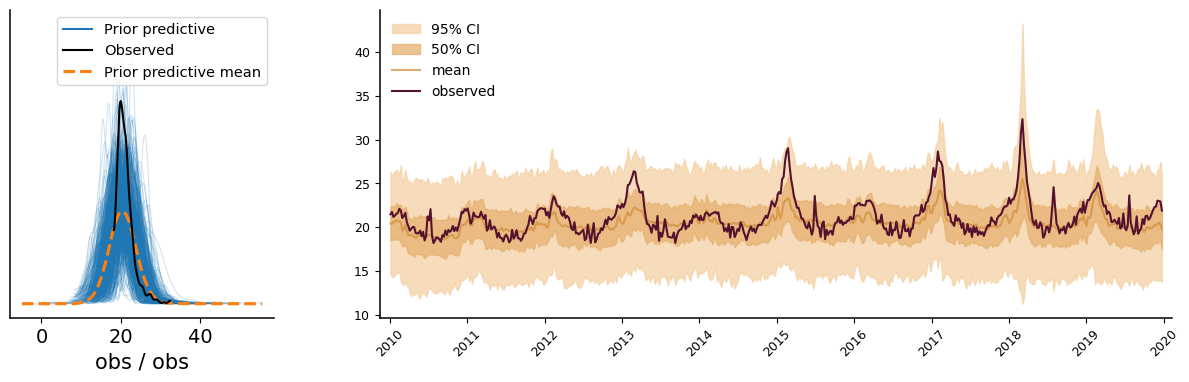

In [81]:
plot_pp(idata, pre_df)

### Inference

This means that we are ready to start sampling from our model. Keeping in mind that the functionality is still experimental (it wasn't possible to use `pm.TruncatedNormal`, for instance), please relish the massive speed-up brought by sampling with `jax`/`numpyro`.

In [82]:
#| code-fold: show

with train_model:
    idata.extend(pm.sampling_jax.sample_numpyro_nuts(draws=2000, tune=2000, random_seed=1, progressbar=False))

Compiling...
Compilation time =  0:00:06.275633
Sampling...
Sampling time =  0:00:13.159124
Transforming variables...
Transformation time =  0:00:00.783038


Thanks to `az.summary()` and `az.plot_trace()` we can quickly see that the sampling ran very smoothly. Also the posterior distributions show no surprises.

In [83]:
#| code-fold: show

az.summary(idata, var_names="~mu")

mean     sd  hdi_3%  hdi_97%  \
intercept                            19.544  0.398  18.738   20.240   
w[0]                                  1.076  0.507   0.172    2.076   
w[1]                                  2.010  0.447   1.193    2.872   
w[2]                                  0.724  0.405  -0.023    1.505   
w[3]                                  0.581  0.452  -0.264    1.438   
w[4]                                  0.653  0.509  -0.333    1.562   
w[5]                                  5.349  0.553   4.340    6.434   
temp lag1 coeff                       0.492  0.106   0.293    0.684   
temp lag2 coeff                       0.501  0.102   0.300    0.683   
age 70-75 coeff                       0.387  0.113   0.186    0.613   
age 75-80 coeff                       0.506  0.145   0.238    0.778   
age 80+ coeff                         0.969  0.138   0.706    1.220   
flu cases 75-79 per 100k lag1 coeff   0.162  0.079   0.015    0.307   
flu cases 80+ per 100k lag1 coeff     0.279  0.077   0.132    0.416   
flu last year coeff                  -0.144  0.043  -0.224   -0.062   
disease cases 75-79 per 100k coeff    0.174  0.070   0.040    0.303   
disease cases 80+ per 100k coeff      0.244  0.076   0.104    0.384   
disease last year coeff              -0.144  0.043  -0.222   -0.059   
temp:flu coeff                        0.285  0.069   0.160    0.416   
flu:disease coeff                     0.165  0.066   0.040    0.285   
disease:age80 coeff                   0.275  0.066   0.159    0.409   
month mu[January]                     0.532  0.166   0.212    0.838   
month mu[February]                    0.660  0.182   0.312    0.994   
month mu[March]                       0.753  0.153   0.461    1.033   
month mu[April]                       0.437  0.120   0.214    0.664   
month mu[May]                        -0.204  0.130  -0.446    0.039   
month mu[June]                       -0.755  0.160  -1.056   -0.460   
month mu[July]                       -0.978  0.176  -1.320   -0.657   
month mu[August]                     -1.085  0.168  -1.406   -0.772   
month mu[September]                  -0.608  0.139  -0.871   -0.343   
month mu[October]                     0.286  0.126   0.042    0.508   
month mu[November]                    0.323  0.143   0.063    0.605   
month mu[December]                    0.640  0.152   0.373    0.944   
sigma                                 0.746  0.024   0.700    0.790   

                                     mcse_mean  mcse_sd  ess_bulk  ess_tail  \
intercept                                0.009    0.006    2249.0    2943.0   
w[0]                                     0.008    0.006    3785.0    4227.0   
w[1]                                     0.009    0.006    2779.0    3425.0   
w[2]                                     0.008    0.006    2443.0    2986.0   
w[3]                                     0.009    0.007    2427.0    3400.0   
w[4]                                     0.010    0.007    2667.0    3728.0   
w[5]                                     0.009    0.007    3527.0    4763.0   
temp lag1 coeff                          0.001    0.001   12613.0    5811.0   
temp lag2 coeff                          0.001    0.001   13429.0    6015.0   
age 70-75 coeff                          0.001    0.001    6576.0    6665.0   
age 75-80 coeff                          0.002    0.001    6176.0    6229.0   
age 80+ coeff                            0.001    0.001    8614.0    5790.0   
flu cases 75-79 per 100k lag1 coeff      0.001    0.001    7674.0    6178.0   
flu cases 80+ per 100k lag1 coeff        0.001    0.001    8396.0    6079.0   
flu last year coeff                      0.000    0.000    8783.0    6722.0   
disease cases 75-79 per 100k coeff       0.001    0.001    9268.0    6433.0   
disease cases 80+ per 100k coeff         0.001    0.001    7683.0    6172.0   
disease last year coeff                  0.000    0.000    8010.0    6819.0   
temp:flu coeff                           0.001    0.

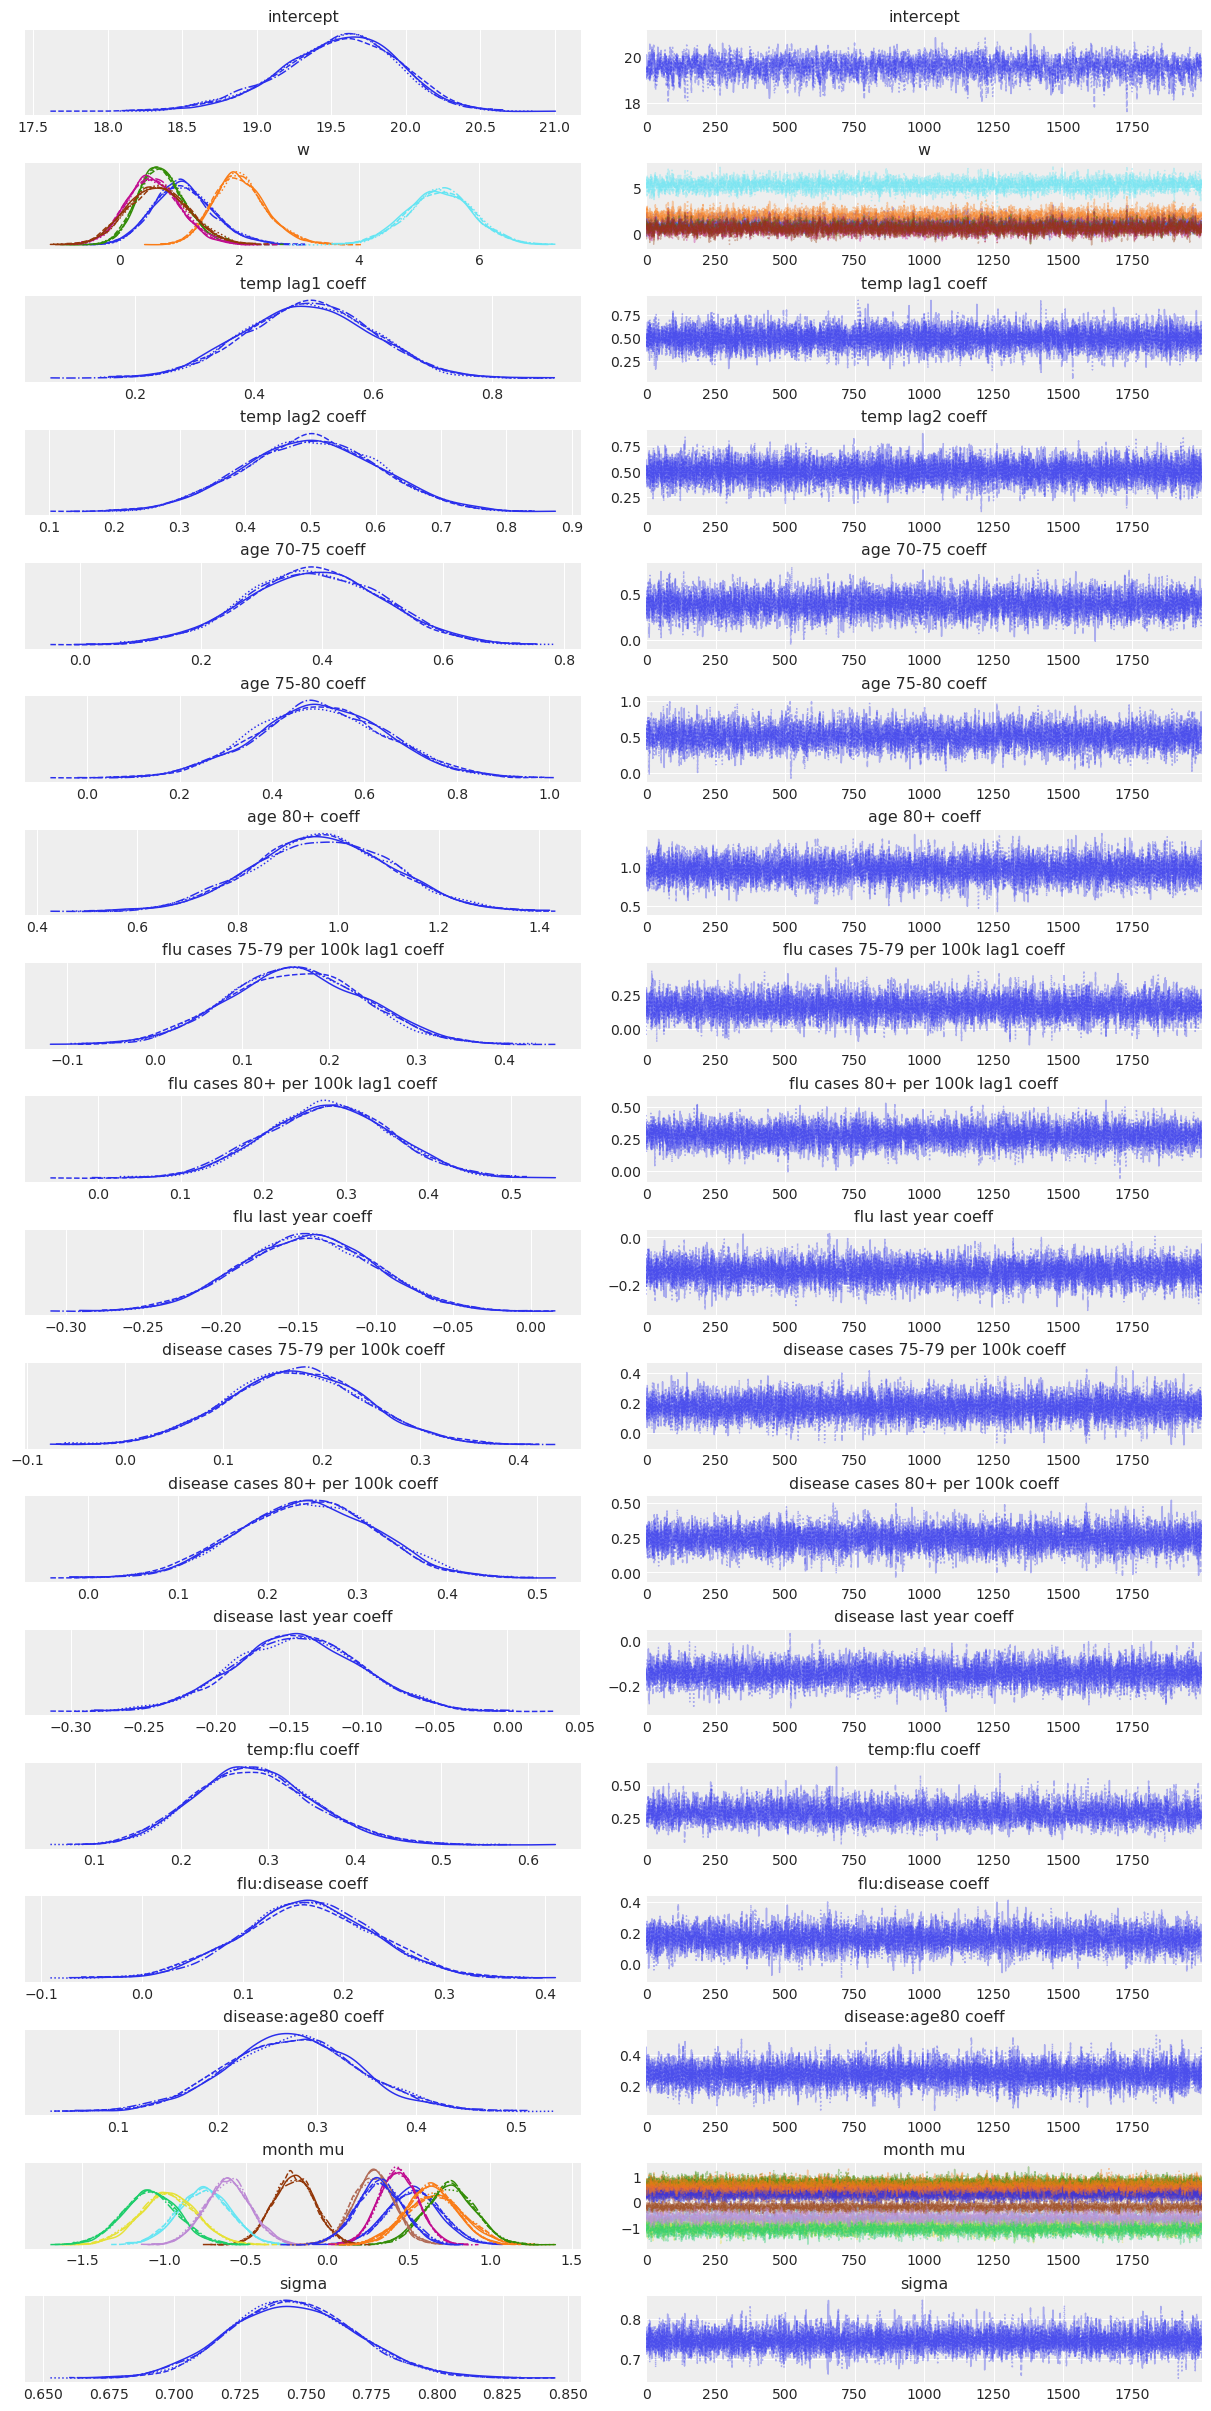

In [84]:
#| code-fold: show

with az.style.context("arviz-darkgrid"):
    az.plot_trace(idata, var_names="~mu", figsize=(12, 24));

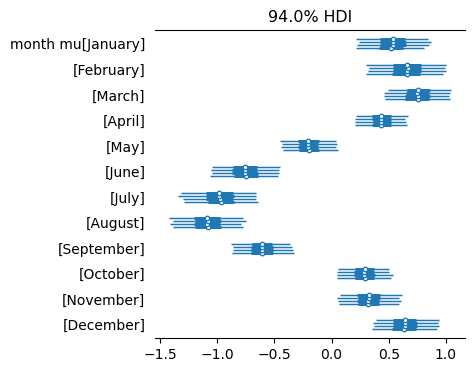

In [85]:
#| code-fold: show

az.plot_forest(idata.posterior, var_names="month mu", textsize=10, figsize=(4, 4));

### Posterior predictive checks

After checking the sampling process, we want to go a step further and check how well the model is able to retrodict the observed data. A reasonable model (with reasonable assumptions) should be able to simulate mortality data that is similar to the original observations in `pre_df`. 

In [86]:
#| code-fold: show

with train_model:
    idata.extend(pm.sample_posterior_predictive(idata, random_seed=1))

In [87]:
#| code-fold: true

def get_hdi_df(preds, hdi_prob_low, hdi_prob_high):
    hdi_dfs = []
    for kind, prob in zip(["low", "high"], [hdi_prob_low, hdi_prob_high]):
        hdi_df = (az.hdi(preds, hdi_prob=prob)
                    .to_dataframe()
                    .reset_index()
                    .pivot_table(index="obs_id", columns="hdi", values="obs")
                    .reset_index()
                    .rename_axis(None, axis=1)
                    .rename(columns={
                        "lower": f"{kind}_lower",
                        "higher": f"{kind}_higher"
                    }))
        hdi_dfs.append(hdi_df)
    hdi_df = pd.merge(left=hdi_dfs[0], right=hdi_dfs[1])
    hdi_df["pred_mean"] = preds.mean(dim=["chain", "draw"])
    return hdi_df

def plot_retrodiction(idata, 
                      pre_df,
                      years=None,
                      hdi_prob_low=0.5,
                      hdi_prob_high=0.95,
                      absolute=False):
    pre_hdi_df = get_hdi_df(idata.posterior_predictive.obs, hdi_prob_low, hdi_prob_high)
    pre_cols = (pre_df.iloc[pre_hdi_df.obs_id.values]
                      .loc[:, ["population", "deaths_total", "deaths_per100k", "covid_deaths_per100k", "year", "week", "date"]]
                      .reset_index(drop=True))
    df = pd.concat([pre_hdi_df, pre_cols], axis=1)
    first_date = df.date.min() if years is None else df.date.max() - timedelta(days=365 * (len(years)-1))
    df = df.loc[df.date >= first_date]

    fig = plt.figure(figsize=(12, 8))
    gs = GridSpec(2, 2, figure=fig)

    ax0 = fig.add_subplot(gs[0, :])
    ax0.set_title(f"Posterior predictive distribution for {df.year.iloc[0]}-{df.year.iloc[-1]}", fontsize=11, pad=1)
    ax0.grid(axis="y", color="#f0f0f0", zorder=1)
    ax0.xaxis.set_minor_locator(mdates.MonthLocator((1, 4, 7, 10)))
    ax0.xaxis.set_minor_formatter(mdates.DateFormatter("%b"))
    ax0.xaxis.set_major_locator(mdates.YearLocator())
    ax0.yaxis.set_major_formatter(FuncFormatter(lambda x, _: format(int(x), ',')))
    ax0.tick_params(axis="x", which="minor", labelbottom=False)
    ax0.tick_params(axis="x", which="major", rotation=45)
    ax0.tick_params(axis="x", which="major", labelsize=10)
    ax0.set_xlim([first_date - timedelta(days=10), df.date.max() + timedelta(days=50)])
    ax0.tick_params(axis="y", which="major", labelsize=10)
    if not absolute:
        ax0.fill_between(df.date, df.high_lower, df.high_higher, color="#f0928b", label=f"{hdi_prob_high * 100:.0f}% CI", zorder=3)
        ax0.fill_between(df.date, df.low_lower, df.low_higher, color="#d9746c", label=f"{hdi_prob_low * 100:.0f}% CI", zorder=4)
        ax0.plot(df.date, df.deaths_per100k, lw=1.5, color="#404040", label="actual deaths", zorder=5)

        ax0.set_ylabel("weekly deaths per 100,000 people", fontsize=10)

        ylim_min, ylim_max = df.low_lower.min() * 0.9, df.deaths_per100k.max() * 1.1
        ax0.set_ylim(ylim_min, ylim_max)
    else:
        mul = df.population.div(100_000)

        ax0.fill_between(df.date, df.high_lower.mul(mul), df.high_higher.mul(mul), color="#f0928b", label=f"{hdi_prob_high * 100:.0f}% CI", zorder=3)
        ax0.fill_between(df.date, df.low_lower.mul(mul), df.low_higher.mul(mul), color="#d9746c", label=f"{hdi_prob_low * 100:.0f}% CI", zorder=4)
        ax0.plot(df.date, df.deaths_total, lw=1.5, color="#404040", label="actual deaths", zorder=5)

        ax0.set_ylabel("weekly deaths", fontsize=10)

        ylim_min, ylim_max = df.low_lower.mul(mul).min() * 0.9, df.deaths_total.max() * 1.1
        ax0.set_ylim(ylim_min, ylim_max)
    ax0.legend(facecolor="white", edgecolor="white", loc="upper left")

    ax1 = fig.add_subplot(gs[1, 0])
    sns.lineplot(x=pre_df.week, y=pre_df.deaths_per100k, hue=pre_df.year, ax=ax1, lw=3)
    ax1.set_title("Observed values")
    handles1, labels1 = ax1.get_legend_handles_labels()
    ax1.legend(handles=handles1[::-1], labels=labels1[::-1], facecolor="white", edgecolor="white")
    ax2 = fig.add_subplot(gs[1, 1])
    sns.lineplot(x=pre_df.week, y=idata.posterior["mu"].mean(dim=["chain", "draw"]).to_numpy(), hue=pre_df.year, ax=ax2, lw=3)
    ax2.set_title("Retrodiction")
    handles2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(handles=handles2[::-1], labels=labels2[::-1], facecolor="white", edgecolor="white")

    for ax in [ax1, ax2]:
        ax.set_ylim(16, 33)

    for ax in [ax0, ax1, ax2]:
        for spine in ["top", "right"]:
            ax.spines[spine].set_visible(False)
        for spine in ["bottom", "left"]:
            ax.spines[spine].set_linewidth(1.5)

    fig.tight_layout();

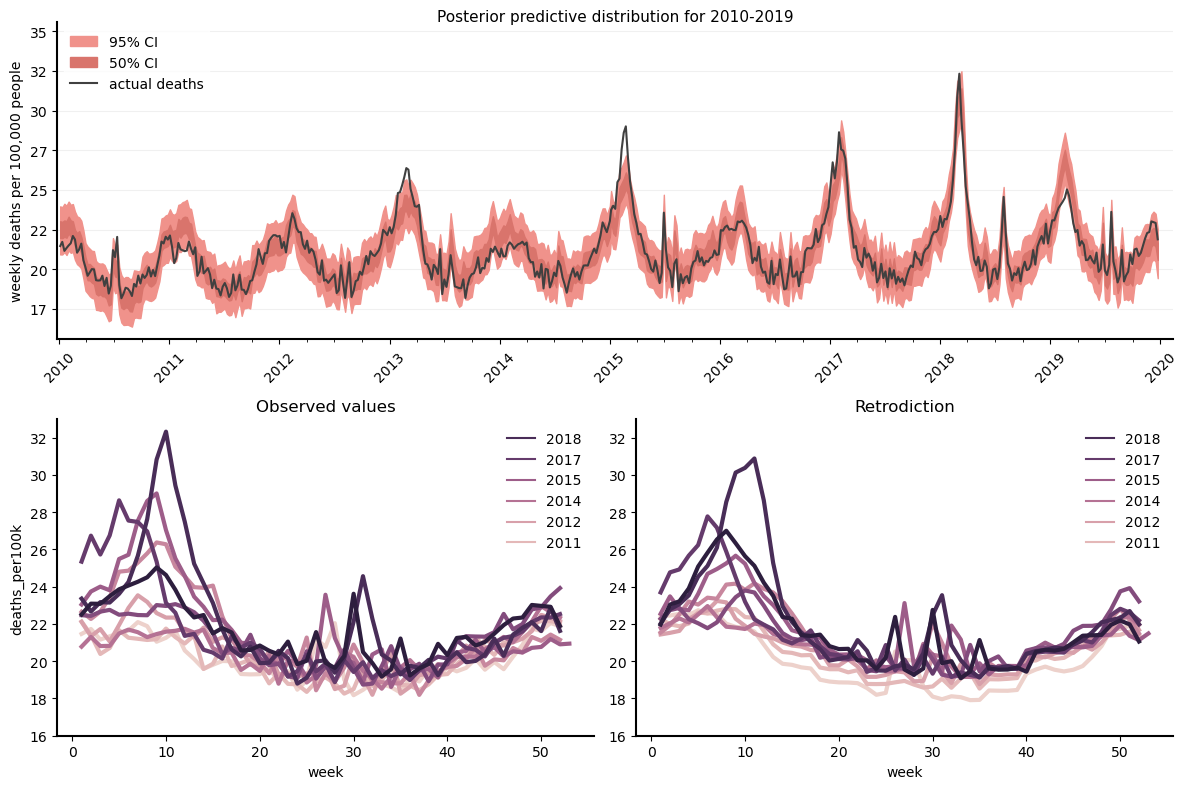

In [88]:
plot_retrodiction(idata, pre_df)

It's probably fair to say that the model performs pretty well. Nonetheless, one issue catches the eye: the model struggles with the peaks of flu season.

Plotting the residuals confirms this suspicion. In more than a few years the model either under- or overestimates mortality at the peak of flu season. Because influenza waves tend to vary in their severity (e.g., due to the changing mix of strains in circulation and the match of the vaccines to these strains), this should probably be expected to some extent, though. Apart from that there is still some amount of variance left in the data that is not quite captured by the model. Given the data constraints this isn't surprising, but still a finding to be aware of.

In [89]:
def plot_residuals(idata, pre_df, hdi_prob_low=0.5, hdi_prob_high=0.95):
    residuals = idata.observed_data.obs - idata.posterior_predictive.obs
    hdi_high = az.hdi(residuals, hdi_prob=hdi_prob_high)
    hdi_low = az.hdi(residuals, hdi_prob=hdi_prob_low)

    _, ax = plt.subplots(figsize=(12, 4))
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)
    for spine in ["bottom", "left"]:
        ax.spines[spine].set_linewidth(1.5)
    ax.set_title(f"Residuals", fontsize=12, pad=10)
    ax.grid(axis="y", color="#f0f0f0", zorder=1)
    ax.axhline(0, color="black", lw=1., zorder=2)
    ax.fill_between(pre_df.date, hdi_high.sel(hdi="lower").obs, hdi_high.sel(hdi="higher").obs, color="#a3c0ff", alpha=0.8, zorder=3)
    ax.fill_between(pre_df.date, hdi_low.sel(hdi="lower").obs, hdi_low.sel(hdi="higher").obs, color="#7399eb", alpha=0.8, zorder=4)
    ax.xaxis.set_minor_locator(mdates.MonthLocator((1, 4, 7, 10)))
    ax.xaxis.set_minor_formatter(mdates.DateFormatter("%b"))
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: format(int(x), ',')))
    ax.tick_params(axis="x", which="minor", labelbottom=False)
    ax.tick_params(axis="x", which="major", rotation=45)
    ax.tick_params(axis="x", which="major", labelsize=10.5)
    ax.tick_params(axis="y", which="major", labelsize=10.5)
    ax.set_xlim(pre_df.date.min() - timedelta(days=10), pre_df.date.max() + timedelta(days=30))
    ax.set_ylim(-6, 6);

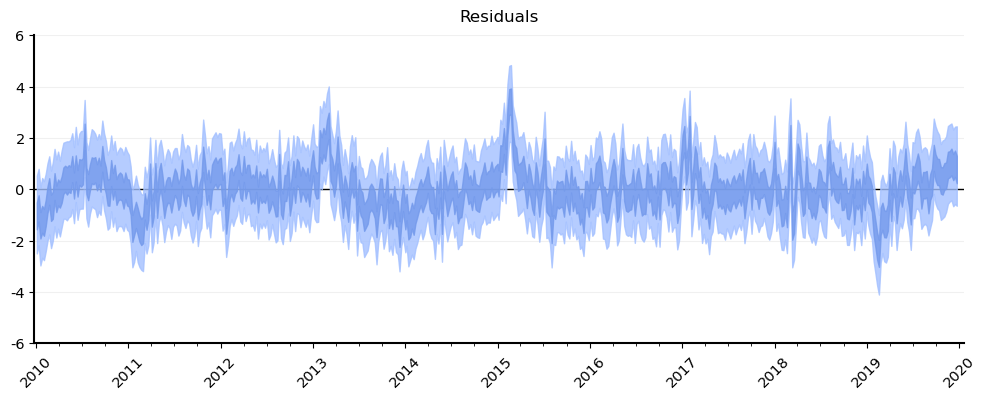

In [90]:
plot_residuals(idata, pre_df)

### Counterfactual inference

Finally we can move on to the most interesting part: the counterfactual forecast of mortality. To do this, we make use of our factory function to get a new model conditioned on `post_df` (the model itself obviously stays the same), set the data accordingly, and run PyMC's `sample_posterior_predictive()`.

In [91]:
pred_model = create_model(pre_df, post_df, infer_post=True)

with pred_model:

    pm.set_data({
        "month": post_df["month"].to_numpy(),
        "temp": post_df["mean_temp_st"].to_numpy(),
        "temp lag1": post_df["min_lt0_lag1"].to_numpy(),
        "temp lag2": post_df["min_lt0_lag2"].to_numpy(),
        "age 70-75": post_df["pop_share_70_74_cnt"].to_numpy(),
        "age 75-80": post_df["pop_share_75_79_cnt"].to_numpy(),
        "age 80+": post_df["pop_share_gt80_cnt"].to_numpy(),
        "flu cases per 100k": post_df["flu_cases_per100k_st"].to_numpy(),
        "flu cases age 75-79 per 100k lag1": post_df["flu_cases_75_79_per100k_lag1_st"].to_numpy(),
        "flu cases age 80+ per 100k lag1": post_df["flu_cases_gt80_per100k_lag1_st"].to_numpy(),
        "flu cases last year": post_df["flu_last_year_st"].to_numpy(),
        "disease cases per 100k": post_df["disease_cases_per100k_st"].to_numpy(),
        "disease cases age 75-79 per 100k": post_df["disease_cases_75_79_per100k_st"].to_numpy(),
        "disease cases age 80+ per 100k": post_df["disease_cases_gt80_per100k_st"].to_numpy(),
        "disease last year": post_df["disease_last_year_st"].to_numpy()
    })

    counterfactual = pm.sample_posterior_predictive(
        idata, var_names=["obs"], random_seed=1
    )

Now we can plot the counterfactual estimate against the reported number of deaths. The colored regions represent the 50% and 95% credible intervals, respectively; the hatched rectangles emphasize the weeks with more (red) or less (yellow) severe federal response measures (i.e., lockdowns). Note that we include the estimate for some months prior to the rise of Covid-19 for better comparison (for these months it is of course the retrodiction, not the counterfactual).

In [92]:
def get_posterior_predictive(idata,
                             counterfactual,
                             pre_df,
                             post_df,
                             hdi_prob_low=0.5, 
                             hdi_prob_high=0.9):
    pre_hdi_df = get_hdi_df(idata.posterior_predictive.obs, hdi_prob_low, hdi_prob_high)
    pre_cols = (pre_df.iloc[pre_hdi_df.obs_id.values]
                      .loc[:, ["population", "deaths_total", "deaths_per100k", "covid_deaths_per100k", "year", "week", "date"]]
                      .reset_index(drop=True))
    pre_hdi_df = pd.concat([pre_hdi_df, pre_cols], axis=1)

    post_hdi_df = get_hdi_df(counterfactual.posterior_predictive.obs, hdi_prob_low, hdi_prob_high)
    post_cols = (post_df.iloc[post_hdi_df.obs_id.values]
                        .loc[:, ["population", "deaths_total", "deaths_per100k", "covid_deaths_per100k", "year", "week", "date"]]
                        .reset_index(drop=True))
    post_hdi_df = pd.concat([post_hdi_df, post_cols], axis=1)

    return pd.concat([pre_hdi_df, post_hdi_df], axis=0)

def plot_posterior_predictive(idata, 
                              counterfactual, 
                              pre_df, 
                              post_df,
                              years=[2018, 2019, 2020, 2021, 2022],
                              hdi_prob_low=0.5,
                              hdi_prob_high=0.95,
                              absolute=False,
                              response_measures=False,
                              dominant_voc=False):
    df = get_posterior_predictive(idata, counterfactual, pre_df, post_df, hdi_prob_low=hdi_prob_low, hdi_prob_high=hdi_prob_high)
    first_date = df.date.max() - timedelta(days=365 * (len(years)-1))
    df = df.loc[df.date >= first_date]
    first_month = df.date.dt.month.iloc[0]
    first_year = df.date.dt.year.iloc[0]
    
    # Setup figure
    fig, ax = plt.subplots(figsize=(14, 6))
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)
    for spine in ["bottom", "left"]:
        ax.spines[spine].set_linewidth(1.5)
    ax.set_title(f"Counterfactual estimate and actual deaths since {first_month}/{first_year}", fontsize=13.5, pad=20)
    ax.grid(axis="y", which="major", color="#e6e5e3", zorder=1)
    ax.xaxis.set_minor_locator(mdates.MonthLocator((1, 4, 7, 10)))
    ax.xaxis.set_minor_formatter(mdates.DateFormatter("%b"))
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
    ax.tick_params(axis="x", which="both", rotation=45)
    ax.tick_params(axis="x", which="minor", labelsize=10)
    ax.tick_params(axis="x", which="major", labelsize=10.5)
    ax.set_xlim([first_date + timedelta(days=10), df.date.max() + timedelta(days=150)])
    ax.tick_params(axis="y", which="major", labelsize=10.5)

    if not absolute:
        ax.fill_between(df[df.year < 2020].date, df[df.year < 2020].high_lower, df[df.year < 2020].high_higher, color="#e8e8e8", zorder=2)
        ax.fill_between(df[df.year < 2020].date, df[df.year < 2020].low_lower, df[df.year < 2020].low_higher, color="#cfcfcf", zorder=3)
        ax.fill_between(df[df.year >= 2020].date, df[df.year >= 2020].high_lower, df[df.year >= 2020].high_higher, color="#f0928b", label=f"{hdi_prob_high * 100:.0f}% CI", zorder=2)
        ax.fill_between(df[df.year >= 2020].date, df[df.year >= 2020].low_lower, df[df.year >= 2020].low_higher, color="#d9746c", label=f"{hdi_prob_low * 100:.0f}% CI", zorder=3)
        ax.plot(df.date, df.deaths_per100k, lw="2", color="#404040", label="actual deaths", zorder=4)

        ax.set_ylabel("weekly deaths per 100,000 people", fontsize=11.5)

        ylim_min, ylim_max = df.low_lower.min() * 0.9, df.deaths_per100k.max() * 1.1
        ax.set_ylim(ylim_min, ylim_max)
    else:
        mul_pre = df[df.year < 2020].population.div(100_000)
        mul_post = df[df.year >= 2020].population.div(100_000)
        ax.fill_between(df[df.year < 2020].date, df[df.year < 2020].high_lower.mul(mul_pre), df[df.year < 2020].high_higher.mul(mul_pre), color="#e8e8e8", zorder=2)
        ax.fill_between(df[df.year < 2020].date, df[df.year < 2020].low_lower.mul(mul_pre), df[df.year < 2020].low_higher.mul(mul_pre), color="#cfcfcf", zorder=3)
        ax.fill_between(df[df.year >= 2020].date, df[df.year >= 2020].high_lower.mul(mul_post), df[df.year >= 2020].high_higher.mul(mul_post), color="#f0928b", label=f"{hdi_prob_high * 100:.0f}% CI", zorder=2)
        ax.fill_between(df[df.year >= 2020].date, df[df.year >= 2020].low_lower.mul(mul_post), df[df.year >= 2020].low_higher.mul(mul_post), color="#d9746c", label=f"{hdi_prob_low * 100:.0f}% CI", zorder=3)
        ax.plot(df.date, df.deaths_total, lw="2", color="#404040", label="actual deaths", zorder=4)

        ax.set_ylabel("weekly deaths", fontsize=11.5)

        ylim_min, ylim_max = df.low_lower.mul(mul_post).min() * 0.9, df.deaths_total.max() * 1.1
        ax.set_ylim(ylim_min, ylim_max)

    # Plot response measures
    if response_measures:
        ax.grid(False)
        for start, end, level in [(pd.Timestamp(year=2020, month=3, day=9), pd.Timestamp(year=2020, month=5, day=5), 2),
                                  (pd.Timestamp(year=2020, month=11, day=2), pd.Timestamp(year=2020, month=12, day=8), 1),
                                  (pd.Timestamp(year=2020, month=12, day=9), pd.Timestamp(year=2021, month=5, day=31), 2),
                                  (pd.Timestamp(year=2021, month=11, day=24), pd.Timestamp(year=2022, month=3, day=19), 1)]:
            level2color = {
                2: "#d97914",
                1: "#fcdb44"
            }
            start = mdates.date2num(start)
            end = mdates.date2num(end)
            width = end - start
            anchor = (start, ylim_min)
            height = (ylim_max - ylim_min) * 0.9

            rect = patches.Rectangle(xy=anchor, width=width, height=height, 
                                     color=level2color[level], hatch="//", 
                                     fill=None, lw=0, zorder=-1)
            ax.add_patch(rect)


    # Plot dominant variants
    if dominant_voc:
        ax.grid(False)
        if not absolute:
            line_ymax = ylim_max * 0.96
            arrow_y = ylim_max * 0.97
            text_y = ylim_max * 0.98
        else:
            line_ymax = ylim_max * 0.96
            arrow_y = ylim_max * 0.97
            text_y = ylim_max * 0.98

        for t, desc, in [(pd.Timestamp(year=2020, month=1, day=27), 
                        "First case detected\n in Germany")]:
            ax.vlines(t, ylim_min, line_ymax, color="black", lw=0.5, zorder=-1)
            ax.text(t, text_y * 0.99, s=desc, ha="center", fontsize=9)
        
        for t, desc in [(pd.Timestamp(year=2021, month=3, day=1), "Alpha"),
                        (pd.Timestamp(year=2021, month=6, day=20), "Delta"),
                        (pd.Timestamp(year=2021, month=12, day=20), "BA. 1"),
                        (pd.Timestamp(year=2022, month=3, day=1), "BA. 2"),
                        (pd.Timestamp(year=2022, month=6, day=10), "BA. 5")]:
            ax.vlines(t, ylim_min, line_ymax, color="black", lw=0.5, zorder=-1)
            width = mdates.date2num(t + pd.Timedelta(days=21)) - mdates.date2num(t)
            head_width = 0.2 if not absolute else ylim_max * 0.0075
            ax.arrow(t, arrow_y, 
                        dx=width, dy=0, 
                        head_width=head_width, 
                        head_length=width*0.3, 
                        lw=0.5,
                        color="black")
            ax.text(t, text_y, s=desc, ha="center", fontsize=9)
        
    ax.legend(facecolor="white", edgecolor="white", loc="upper right")

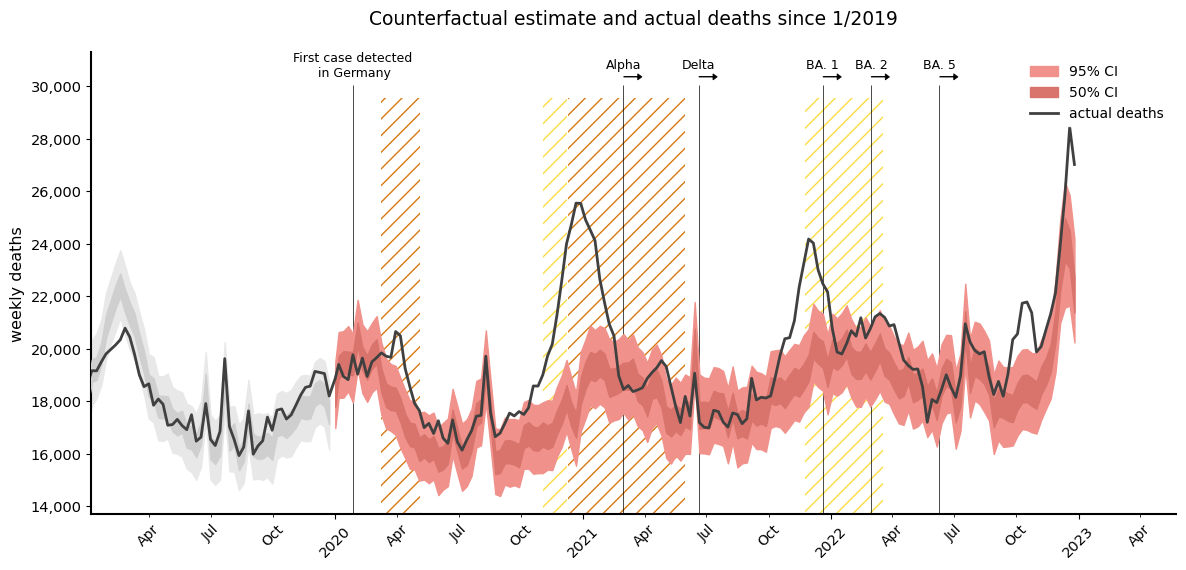

In [93]:
plot_posterior_predictive(idata, 
                          counterfactual, 
                          pre_df, 
                          post_df, 
                          absolute=True, 
                          response_measures=True, 
                          dominant_voc=True)

Sadly, Covid-19 appears to have caused a significant rise in mortality in many weeks and months of the pandemic. Let's go through this chronologically: After the first (and in hindsight small) wave, the first summer of the pandemic saw low case numbers in Germany and therefore virtually no excess deaths (the one major spike was likely due to a heat wave and expected by the model). In the fall of 2020 case numbers started to rise again, culminating in the second wave which was associated with a high increase in mortality. This repeated itself in the fall and winter of 2021 when the third wave led to a significant number of excess deaths. Since then mortality still appears to follow anomalous patterns. For the last weeks of 2022, however, we should remind ourselves that the model probably significantly underestimates the severity of the flu wave. This wasn't an issue during most months of the Covid-19 pandemic (since there were virtually no flu cases), but towards the end of the year 2022 flu cases actually soared for the first time since its beginning and the wave was described as quite severe (probably due to the waning immunity of the population).

Let's change the perspective and look specifically at excess mortality since 2020:

In [74]:
def get_excess_deaths(counterfactual, year=None, month=None):
    if year is None:
        cf = counterfactual.posterior_predictive.obs
        deaths = xr.DataArray(post_df["deaths_per100k"].to_numpy(), dims=["obs_id"])
    else:
        if month is None:
            cf = counterfactual.posterior_predictive.obs.isel(obs_id=post_df[post_df.year == year].index)
            deaths = xr.DataArray(post_df[post_df.year == year]["deaths_per100k"].to_numpy(), dims=["obs_id"])
        else:
            cf = counterfactual.posterior_predictive.obs.isel(obs_id=post_df[(post_df.year == year) & (post_df.month == month)].index)
            deaths = xr.DataArray(post_df[(post_df.year == year) & (post_df.month == month)]["deaths_per100k"].to_numpy(), dims=["obs_id"])
    excess_deaths = deaths - cf
    cum_excess = excess_deaths.cumsum(dim="obs_id")

    return excess_deaths.transpose(..., "obs_id"), cum_excess.transpose(..., "obs_id")

def get_cf_hdi_df(preds, hdi_prob_low, hdi_prob_high):
    hdi_dfs = []
    for kind, prob in zip(["low", "high"], [hdi_prob_low, hdi_prob_high]):
        hdi_df = (az.hdi(preds, hdi_prob=prob)
                    .to_dataframe()
                    .reset_index()
                    .pivot_table(index="obs_id", columns="hdi", values="obs_id")
                    .reset_index()
                    .rename_axis(None, axis=1)
                    .rename(columns={
                        "lower": f"{kind}_lower",
                        "higher": f"{kind}_higher"
                    }))
        hdi_dfs.append(hdi_df)
    hdi_df = pd.merge(left=hdi_dfs[0], right=hdi_dfs[1])
    hdi_df["pred_mean"] = preds.mean(dim=["chain", "draw"])

    post_cols = (post_df.iloc[hdi_df.obs_id.values]
                        .loc[:, ["population", "deaths_total", "deaths_per100k", "covid_deaths_per100k", "year", "week", "date"]]
                        .reset_index(drop=True))
    hdi_df = pd.concat([hdi_df, post_cols], axis=1)

    return hdi_df

def plot_excess_deaths(counterfactual,
                       hdi_prob_low=0.5, 
                       hdi_prob_high=0.95, 
                       absolute=True):

    excess_deaths, cumsum = get_excess_deaths(counterfactual)

    fig, ax = plt.subplots(figsize=(15, 5))
    ax.tick_params(axis="x", which="both", bottom=False)
    ax.tick_params(axis="y", which="major", labelsize=10)
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)
    for spine in ["bottom", "left"]:
        ax.spines[spine].set_linewidth(1.2)
    ax.set_title(f"Estimated excess deaths in Germany since 01/20", fontsize=14)

    excess_df = get_cf_hdi_df(excess_deaths, hdi_prob_low, hdi_prob_high)

    xlim_min = pd.Timestamp(year=2019, month=12, day=30)

    if not absolute:
        excess_ylim_min = excess_df.high_lower.min() * 1.3
        excess_ylim_max = excess_df.high_higher.max() * 1.3
        ax.plot(excess_df.date, excess_df.covid_deaths_per100k, lw=2.5, color="#44454a", label="official\nC19 deaths")
        ax.fill_between(excess_df.date, excess_df.high_lower, excess_df.high_higher, color="#f0928b", alpha=0.75, label=f"{hdi_prob_high * 100:.0f}% CI")
        ax.fill_between(excess_df.date, excess_df.low_lower, excess_df.low_higher, color="#d9746c", alpha=0.75, label=f"{hdi_prob_low * 100:.0f}% CI")
        ax.hlines(y=0, xmin=xlim_min, xmax=excess_df.date.max(), lw=1.5, ls="--", color="black")
        ax.set_ylabel("weekly excess deaths per 100,000 people", fontsize=11)
        
    else: 
        mul = excess_df.population / 100_000
        excess_ylim_min = excess_df.high_lower.mul(mul).min() * 1.3
        excess_ylim_max = excess_df.high_higher.mul(mul).max() * 1.3
        ax.fill_between(excess_df.date, excess_df.high_lower.mul(mul), excess_df.high_higher.mul(mul), color="#f0928b", alpha=0.75, label=f"{hdi_prob_high * 100:.0f}% CI")
        ax.fill_between(excess_df.date, excess_df.low_lower.mul(mul), excess_df.low_higher.mul(mul), color="#d9746c", alpha=0.75, label=f"{hdi_prob_low * 100:.0f}% CI")
        ax.plot(excess_df.date, excess_df.covid_deaths_per100k.mul(mul), lw=2.5, color="#44454a", label="official\nC19 deaths")
        ax.hlines(y=0, xmin=xlim_min, xmax=excess_df.date.max(), lw=1.5, ls="--", color="black")
        ax.set_ylabel("weekly excess deaths", fontsize=11, labelpad=15)
    
    for y in ax.get_yticks()[1:-1]:
        ax.hlines(y=y, xmin=xlim_min, xmax=excess_df.date.max(), lw=0.5, color="#a1a1a1", zorder=-10)
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
    ax.legend(facecolor="white", edgecolor="white", loc="upper left")
    ax.xaxis.set_minor_locator(mdates.MonthLocator(range(1, 13)))
    ax.xaxis.set_minor_formatter(mdates.DateFormatter("%b"))
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.tick_params(axis="x", which="both", rotation=45)
    ax.tick_params(axis="x", which="minor", labelsize=9.5)
    ax.tick_params(axis="x", which="major", labelsize=11.5)
    ax.set_xlim([pd.Timestamp(year=2019, month=12, day=1) + timedelta(days=10), post_df.date.max() + timedelta(days=30)])

    plt.subplots_adjust(hspace=0.1)

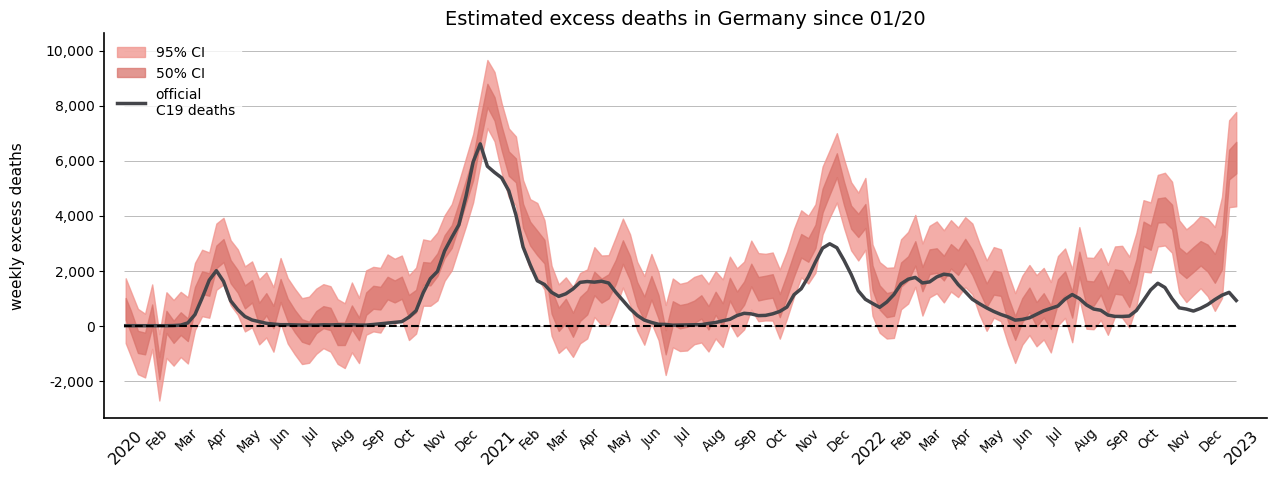

In [75]:
plot_excess_deaths(counterfactual)

We can see that the model's predictions of excess mortality generally follow the official count of deaths that were "associated with Covid-19" quite closely. However, in weeks with many Covid-19 deaths (around the peaks of the infection waves) actual mortality figures appear to have been higher than what was officially recorded. In these weeks, many hospitals were running at full capacity, so Covid-19 may have been (at least in part) the indirect rather than the direct cause of these additional deaths. In any case, we can probably conclude that excess mortality due to Covid-19 hasn't been significantly overestimated in Germany.


## The Hierarchical Model

Until now we have looked at the aggregated data for Germany, but the title of this blog post promised a hierarchical model. So let's build a hierarchical model for estimating excess mortality in the German states! Why a hierarchical model? The alternatives would be either a complete pooled model, which assumes that one model is appropriate for estimating mortality in all states, or an unpooled model, which assumes that a model for one state doesn't contain information that is relevant for other states. Given that the German states are quite similar but certainly differ to some degree in relevant aspects (population density, access to and quality of health care, geography, etc.), a hierarchical model is the better choice.

In [95]:
def standardize_by_state(pre_df, post_df, feature):
    pre_st = np.zeros(pre_df.shape[0])
    post_st = np.zeros(post_df.shape[0])

    for state in df["state"].unique():
        pre_mask = pre_df["state"] == state
        post_mask = post_df["state"] == state
        pre_vals = pre_df.loc[pre_mask, feature]
        post_vals = post_df.loc[post_mask, feature]

        ss = StandardScaler()
        ss.fit(pre_vals.values.reshape(-1, 1))

        pre_st[pre_mask] = ss.transform(pre_vals.values.reshape(-1, 1)).ravel()
        post_st[post_mask] = ss.transform(post_vals.values.reshape(-1, 1)).ravel()
    
    return pre_st, post_st

def create_datasets(df):
    df["is_pre_covid"] = df["year"] < 2020

    df = df.loc[df.year.isin(range(2010, 2023))]

    pre_df = df[df["is_pre_covid"]].copy()
    post_df = df[~df["is_pre_covid"]].copy()

    for feature in ["mean_temp", 
                    "pop_share_70",
                    "pop_share_75",
                    "pop_share_80",
                    "flu_cases_per100k", 
                    "flu_cases_per100k_lag1",
                    "flu_cases_75_per100k",
                    "flu_cases_75_per100k_lag1",
                    "flu_cases_80_per100k",
                    "flu_cases_80_per100k_lag1",
                    "flu_cases_last_year",
                    "disease_cases_per100k",
                    "disease_cases_per100k_lag1",
                    "disease_cases_75_per100k",
                    "disease_cases_75_per100k_lag1",
                    "disease_cases_80_per100k",
                    "disease_cases_80_per100k_lag1",
                    "disease_cases_last_year"]:
        pre_df[f"{feature}_st"], post_df[f"{feature}_st"] =  standardize_by_state(pre_df, post_df, feature)

    return pre_df, post_df

In [96]:
data_path = Path("../data/final/states.ftr")
map_path = Path("../data/final/maps")
abbr_path = Path("../data/raw/states/abbr2name.pkl")

with open(abbr_path, "rb") as f:
    abbr2name = pickle.load(f)

df = pd.read_feather(data_path)
pre_df, post_df = create_datasets(df.copy())

Let's have a quick look at the data again (no worries, we'll keep this much more concise).

For example, let's plot the mortality figures of Bavaria, the state with the highest GDP per capita (at least when we ignore the city-states of Bremen and Hamburg), and Mecklenburg-Western Pomerania, the state with the lowest GDP per capita. As we can see, the difference between states can be quite distinct. (There are many reasons for this; the different age structure probably being the most important one.)

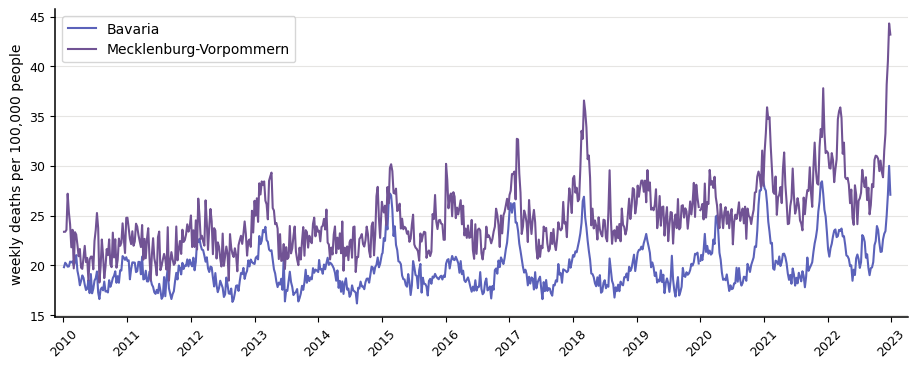

In [98]:
pre_by, post_by = pre_df[pre_df.state == "by"].copy(), post_df[post_df.state == "by"].copy()
pre_mv, post_mv = pre_df[pre_df.state == "mv"].copy(), post_df[post_df.state == "mv"].copy()

ax = get_plot(ylabel="weekly deaths per 100,000 people")
ax.plot(pre_by.date, pre_by.deaths_per100k, color="#5b62ba", zorder=2, label="Bavaria")
ax.plot(post_by.date, post_by.deaths_per100k, color="#5b62ba", zorder=2)
ax.plot(pre_mv.date, pre_mv.deaths_per100k, color="#715394", zorder=2, label="Mecklenburg-Vorpommern")
ax.plot(post_mv.date, post_mv.deaths_per100k, color="#715394", zorder=2)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.set_xlim([pre_df.date.min() - timedelta(days=50), post_df.date.max() + timedelta(days=100)])
ax.tick_params(axis="x", which="both", rotation=45)
ax.legend();

Let's continue with the definition of the model. The key idea in hierarchical models is that groups don't share a fixed parameter but a *hyperprior distribution* which describes the distribution of the prior's parameters. Thus, each group has its own prior parameters which are drawn from a common hyperprior distribution. If you need more information, the PyMC documentation includes a nice [primer](https://www.pymc.io/projects/examples/en/latest/case_studies/multilevel_modeling.html) on hierarchical Bayesian models and a handful of [examples](https://www.pymc.io/projects/examples/en/latest/blog/tag/hierarchical-model.html) for different topics. For more info regarding model reparameterization see [here](https://twiecki.io/blog/2017/02/08/bayesian-hierchical-non-centered/) and [here](https://num.pyro.ai/en/latest/tutorials/bad_posterior_geometry.html).

In [99]:
def create_model(pre_df, post_df, infer_post=False, num_knots=5):

    # Define the dataset
    df = pre_df if not infer_post else post_df

    # Define the design matrix for the splines
    knot_list = np.quantile(pre_df.mean_temp, np.linspace(0, 1, num_knots))
    B = dmatrix("0 + bs(mean_temp, knots=knots, degree=2, include_intercept=True)",
                {"mean_temp": df.mean_temp.values, "knots": knot_list[1:-1]})

    # Define the model coords
    state_idxs, states = pd.factorize(df["state"])
    month_strings = calendar.month_name[1:]
    coords = {
        "month": month_strings,
        "state": states,
        "splines": np.arange(B.shape[1])
    }

    # Define the model
    with pm.Model(coords=coords) as model:

        # observed data
        state_idx = pm.MutableData("state_idx", state_idxs, dims="obs_id")
        time = pm.MutableData("time", df["t"].to_numpy(), dims="obs_id")
        month = pm.MutableData("month", df["month"].to_numpy(), dims="obs_id")

        mean_temp = pm.MutableData("mean temp", df["mean_temp_st"].to_numpy(), dims="obs_id")
        temp_lag1 = pm.MutableData("temp lag1", df["min_lt0_lag1"].to_numpy(), dims="obs_id")
        temp_lag2 = pm.MutableData("temp lag2", df["min_lt0_lag2"].to_numpy(), dims="obs_id")

        age_70 = pm.MutableData("age 70-75", df["pop_share_70_st"].to_numpy(), dims="obs_id")
        age_75 = pm.MutableData("age 75-80", df["pop_share_75_st"].to_numpy(), dims="obs_id")
        age_80 = pm.MutableData("age 80+", df["pop_share_80_st"].to_numpy(), dims="obs_id")

        flu_75_lag1 = pm.MutableData("flu cases per 100k age 75-79 lag1", df["flu_cases_75_per100k_lag1_st"].to_numpy(), dims="obs_id")
        flu_80_lag1 = pm.MutableData("flu cases per 100k age 80+ lag1", df["flu_cases_80_per100k_lag1_st"].to_numpy(), dims="obs_id")
        
        disease_75 = pm.MutableData("disease cases per 100k age 75-79", df["disease_cases_75_per100k_st"].to_numpy(), dims="obs_id")
        disease_80 = pm.MutableData("disease cases per 100k age 80+", df["disease_cases_80_per100k_st"].to_numpy(), dims="obs_id")
      
        deaths = pm.MutableData("deaths per 100k", df["deaths_per100k"].to_numpy(), dims="obs_id")
        
        # hyperpriors
        intercept_mu = pm.Normal("intercept_mu", mu=22., sigma=2.)
        intercept_sigma = pm.HalfNormal("intercept sigma", 1.)

        temp_lag1_mu = pm.Normal("temp lag1 mu", mu=1., sigma=0.3)
        temp_lag1_sigma = pm.Normal("temp lag1 sigma", mu=0.5, sigma=0.1)
        temp_lag2_mu = pm.Normal("temp lag2 mu", mu=1., sigma=0.3)
        temp_lag2_sigma = pm.Normal("temp lag2 sigma", mu=0.5, sigma=0.1)

        age_70_mu = pm.Normal("age 70-75 mu", mu=0.5, sigma=0.25)
        age_70_sigma = pm.Normal("age 70-75 sigma", mu=1., sigma=0.1)
        age_75_mu = pm.Normal("age 75-80 mu", mu=0.75, sigma=0.25)
        age_75_sigma = pm.Normal("age 75-80 sigma", mu=1., sigma=0.1)
        age_80_mu = pm.Normal("age 80+ mu", mu=1.25, sigma=0.25)
        age_80_sigma = pm.Normal("age 80+ sigma", mu=1., sigma=0.1)

        flu_75_lag1_mu = pm.Normal("flu cases per 100k age 75-79 lag1 mu", mu=0.5, sigma=0.5)
        flu_75_lag1_sigma = pm.Normal("flu cases per 100k age 75-79 lag1 sigma", mu=0.5, sigma=0.1)
        flu_80_lag1_mu = pm.Normal("flu cases per 100k age 80+ lag1 mu", mu=0.5, sigma=0.5)
        flu_80_lag1_sigma = pm.Normal("flu cases per 100k age 80+ lag1 sigma", mu=0.5, sigma=0.1)

        disease_75_mu = pm.Normal("disease cases per 100k age 75-79 mu", mu=0.75, sigma=0.5)
        disease_75_sigma = pm.Normal("disease cases per 100k age 75-79 sigma", mu=0.5, sigma=0.1)
        disease_80_mu = pm.Normal("disease cases per 100k age 80+ mu", mu=0.75, sigma=0.5)
        disease_80_sigma = pm.Normal("disease cases per 100k age 80+ sigma", mu=0.5, sigma=0.1)

        # priors
        intercept_offset = pm.Normal("intercept offset", mu=0., sigma=1., dims="state")
        intercept = pm.Deterministic("intercept", intercept_mu + intercept_offset * intercept_sigma)

        month_mu = pm.ZeroSumNormal("month mu", sigma=4, dims="month")

        temp_lag1_offset = pm.Normal("temp lag1 offset", mu=0, sigma=0.5, dims="state")
        temp_lag1_coeff = pm.Deterministic("temp lag1 coeff", temp_lag1_mu + temp_lag1_offset * temp_lag1_sigma)
        temp_lag2_offset = pm.Normal("temp lag2 offset", mu=0, sigma=0.5, dims="state")
        temp_lag2_coeff = pm.Deterministic("temp lag2 coeff", temp_lag2_mu + temp_lag2_offset * temp_lag2_sigma)

        age_70_offset = pm.Normal("age 70-75 offset", mu=0, sigma=0.5, dims="state")
        age_70_coeff = pm.Deterministic("age 70-75 coeff", age_70_mu + age_70_offset * age_70_sigma)
        age_75_offset = pm.Normal("age 75-80 offset", mu=0, sigma=0.5, dims="state")
        age_75_coeff = pm.Deterministic("age 75-80 coeff", age_75_mu + age_75_offset * age_75_sigma)
        age_80_offset = pm.Normal("age 80+ offset", mu=0, sigma=0.5, dims="state")
        age_80_coeff = pm.Deterministic("age 80+ coeff", age_80_mu + age_80_offset * age_80_sigma)

        flu_75_lag1_offset = pm.Normal("flu cases per 100k age 75-79 lag1 offset", mu=0, sigma=0.5, dims="state")
        flu_75_lag1_coeff = pm.Deterministic("flu cases per 100k age 75-79 lag1 coeff", flu_75_lag1_mu + flu_75_lag1_offset * flu_75_lag1_sigma)
        flu_80_lag1_offset = pm.Normal("flu cases per 100k age 80+ lag1 offset", mu=0, sigma=0.5, dims="state")
        flu_80_lag1_coeff = pm.Deterministic("flu cases per 100k age 80+ lag1 coeff", flu_80_lag1_mu + flu_80_lag1_offset * flu_80_lag1_sigma)
  
        disease_75_offset = pm.Normal("disease cases per 100k age 75-79 offset", mu=0, sigma=0.5, dims="state")
        disease_75_coeff = pm.Deterministic("disease cases per 100k age 75-79 coeff", disease_75_mu + disease_75_offset * disease_75_sigma)
        disease_80_offset = pm.Normal("disease cases per 100k age 80+ offset", mu=0, sigma=0.5, dims="state")
        disease_80_coeff = pm.Deterministic("disease cases per 100k age 80+ coeff", disease_80_mu + disease_80_offset * disease_80_sigma)
     
        # temperature splines
        sd_dist = pm.Gamma.dist(2, 0.5, shape=B.shape[1])
        chol, corr, stds = pm.LKJCholeskyCov(
            "chol", eta=2, n=B.shape[1], sd_dist=sd_dist, compute_corr=True
        )
        cov = pm.Deterministic("cov", chol.dot(chol.T))
        w_mu = pm.Normal("w mu", mu=0., sigma=1., shape=(B.shape[1], 1))
        w_delta = pm.Normal("w_delta", mu=0., sigma=1., shape=(B.shape[1], len(states)))
        w = pm.Deterministic("w", w_mu + at.dot(chol, w_delta))
        sp = []
        for i in range(len(states)):
            sp.append(at.dot(np.asarray(B[state_idxs == i, :]), w[:, i]).reshape((-1, 1)))

        # model
        mu = pm.Deterministic("mu", intercept[state_idx] + \
                                    month_mu[month - 1] + \
                                    at.vertical_stack(*sp).squeeze() + \
                                    temp_lag1_coeff[state_idx] * temp_lag1 + \
                                    temp_lag2_coeff[state_idx] * temp_lag2 + \
                                    age_70_coeff[state_idx] * age_70 + \
                                    age_75_coeff[state_idx] * age_75 + \
                                    age_80_coeff[state_idx] * age_80 + \
                                    flu_75_lag1_coeff[state_idx] * flu_75_lag1 + \
                                    flu_80_lag1_coeff[state_idx] * flu_80_lag1 + \
                                    disease_75_coeff[state_idx] * disease_75 + \
                                    disease_80_coeff[state_idx] * disease_80, dims="obs_id")
                                    
        sigma = pm.HalfNormal("sigma", 1, dims="state")

        # likelihood
        pm.Normal("obs", mu=mu, sigma=sigma[state_idx], observed=deaths, dims="obs_id")

    return model

In [100]:
train_model = create_model(pre_df, post_df)

In [101]:
#| code-fold: show

with train_model:
    idata = pm.sample_prior_predictive(random_seed=1)

Sampling: [age 70-75 mu, age 70-75 offset, age 70-75 sigma, age 75-80 mu, age 75-80 offset, age 75-80 sigma, age 80+ mu, age 80+ offset, age 80+ sigma, chol, disease cases per 100k age 75-79 mu, disease cases per 100k age 75-79 offset, disease cases per 100k age 75-79 sigma, disease cases per 100k age 80+ mu, disease cases per 100k age 80+ offset, disease cases per 100k age 80+ sigma, flu cases per 100k age 75-79 lag1 mu, flu cases per 100k age 75-79 lag1 offset, flu cases per 100k age 75-79 lag1 sigma, flu cases per 100k age 80+ lag1 mu, flu cases per 100k age 80+ lag1 offset, flu cases per 100k age 80+ lag1 sigma, intercept offset, intercept sigma, intercept_mu, month mu, obs, sigma, temp lag1 mu, temp lag1 offset, temp lag1 sigma, temp lag2 mu, temp lag2 offset, temp lag2 sigma, w mu, w_delta]


The prior predictive plot looks solid (for brevity we only look at one plot for all 16 states):

In [103]:
def plot_pp(idata, pre_df):
    pp_quantiles = idata.prior_predictive["obs"].quantile((0.025, 0.25, 0.5, 0.75, 0.975), dim=("chain", "draw")).transpose()

    _, axs = plt.subplots(1, 2, figsize=(15, 4), width_ratios=[1, 3])
    for ax in axs:
        ax.tick_params(axis="both", labelsize=9)
        for spine in ["top", "right"]:
            ax.spines[spine].set_visible(False)
        for spine in ["bottom", "left"]:
            ax.spines[spine].set_linewidth(1.1)
    with az.style.context("arviz-plasmish"):
        az.plot_ppc(idata, group="prior", ax=axs[0])
    axs[1].fill_between(pre_df.date, pp_quantiles.sel(quantile=[0.025]).to_numpy().ravel(), pp_quantiles.sel(quantile=[0.975]).to_numpy().ravel(), color="#f5d1a4", alpha=0.75, label="95% CI", zorder=1)
    axs[1].fill_between(pre_df.date, pp_quantiles.sel(quantile=[0.25]).to_numpy().ravel(), pp_quantiles.sel(quantile=[0.75]).to_numpy().ravel(), color="#e6b170", alpha=0.75, label="50% CI", zorder=2)
    axs[1].plot(pre_df.date, pp_quantiles.sel(quantile=0.5), color="#d18f3f", alpha=0.75, label="mean", zorder=3)
    axs[1].scatter(pre_df.date, pre_df.deaths_per100k, color="#55122f", label="observed", zorder=4, s=0.25)

    axs[1].grid(False)
    axs[1].xaxis.set_major_locator(mdates.YearLocator())
    axs[1].set_xlim([pre_df.date.min() - timedelta(days=50), pre_df.date.max() + timedelta(days=50)])
    axs[1].tick_params(axis="x", which="both", rotation=45)
    axs[1].legend(facecolor="white", edgecolor="white", loc="upper left");

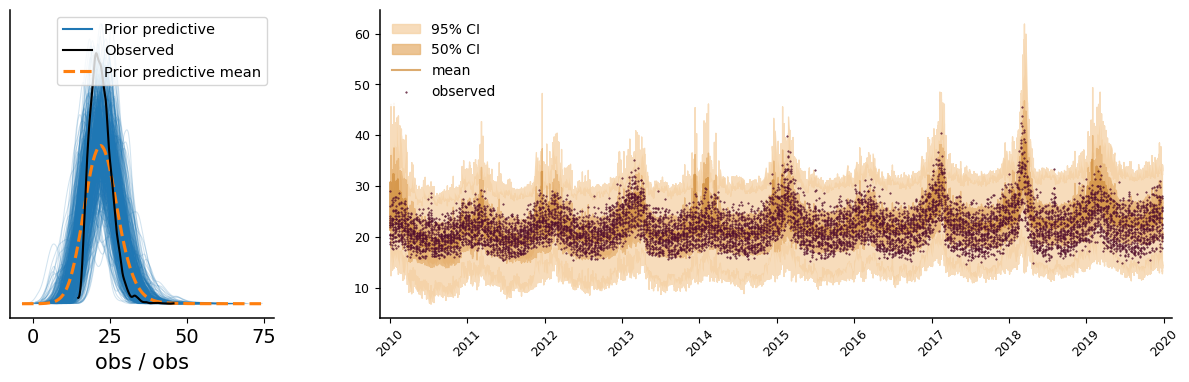

In [104]:
plot_pp(idata, pre_df)

In [105]:
#| code-fold: show

with train_model:
    idata.extend(pm.sampling_jax.sample_numpyro_nuts(draws=1000, tune=1000, random_seed=1, progressbar=False))

Compiling...
Compilation time =  0:00:18.643953
Sampling...
Sampling time =  0:05:17.676316
Transforming variables...
Transformation time =  0:00:10.056034


And the traces look okay, too:

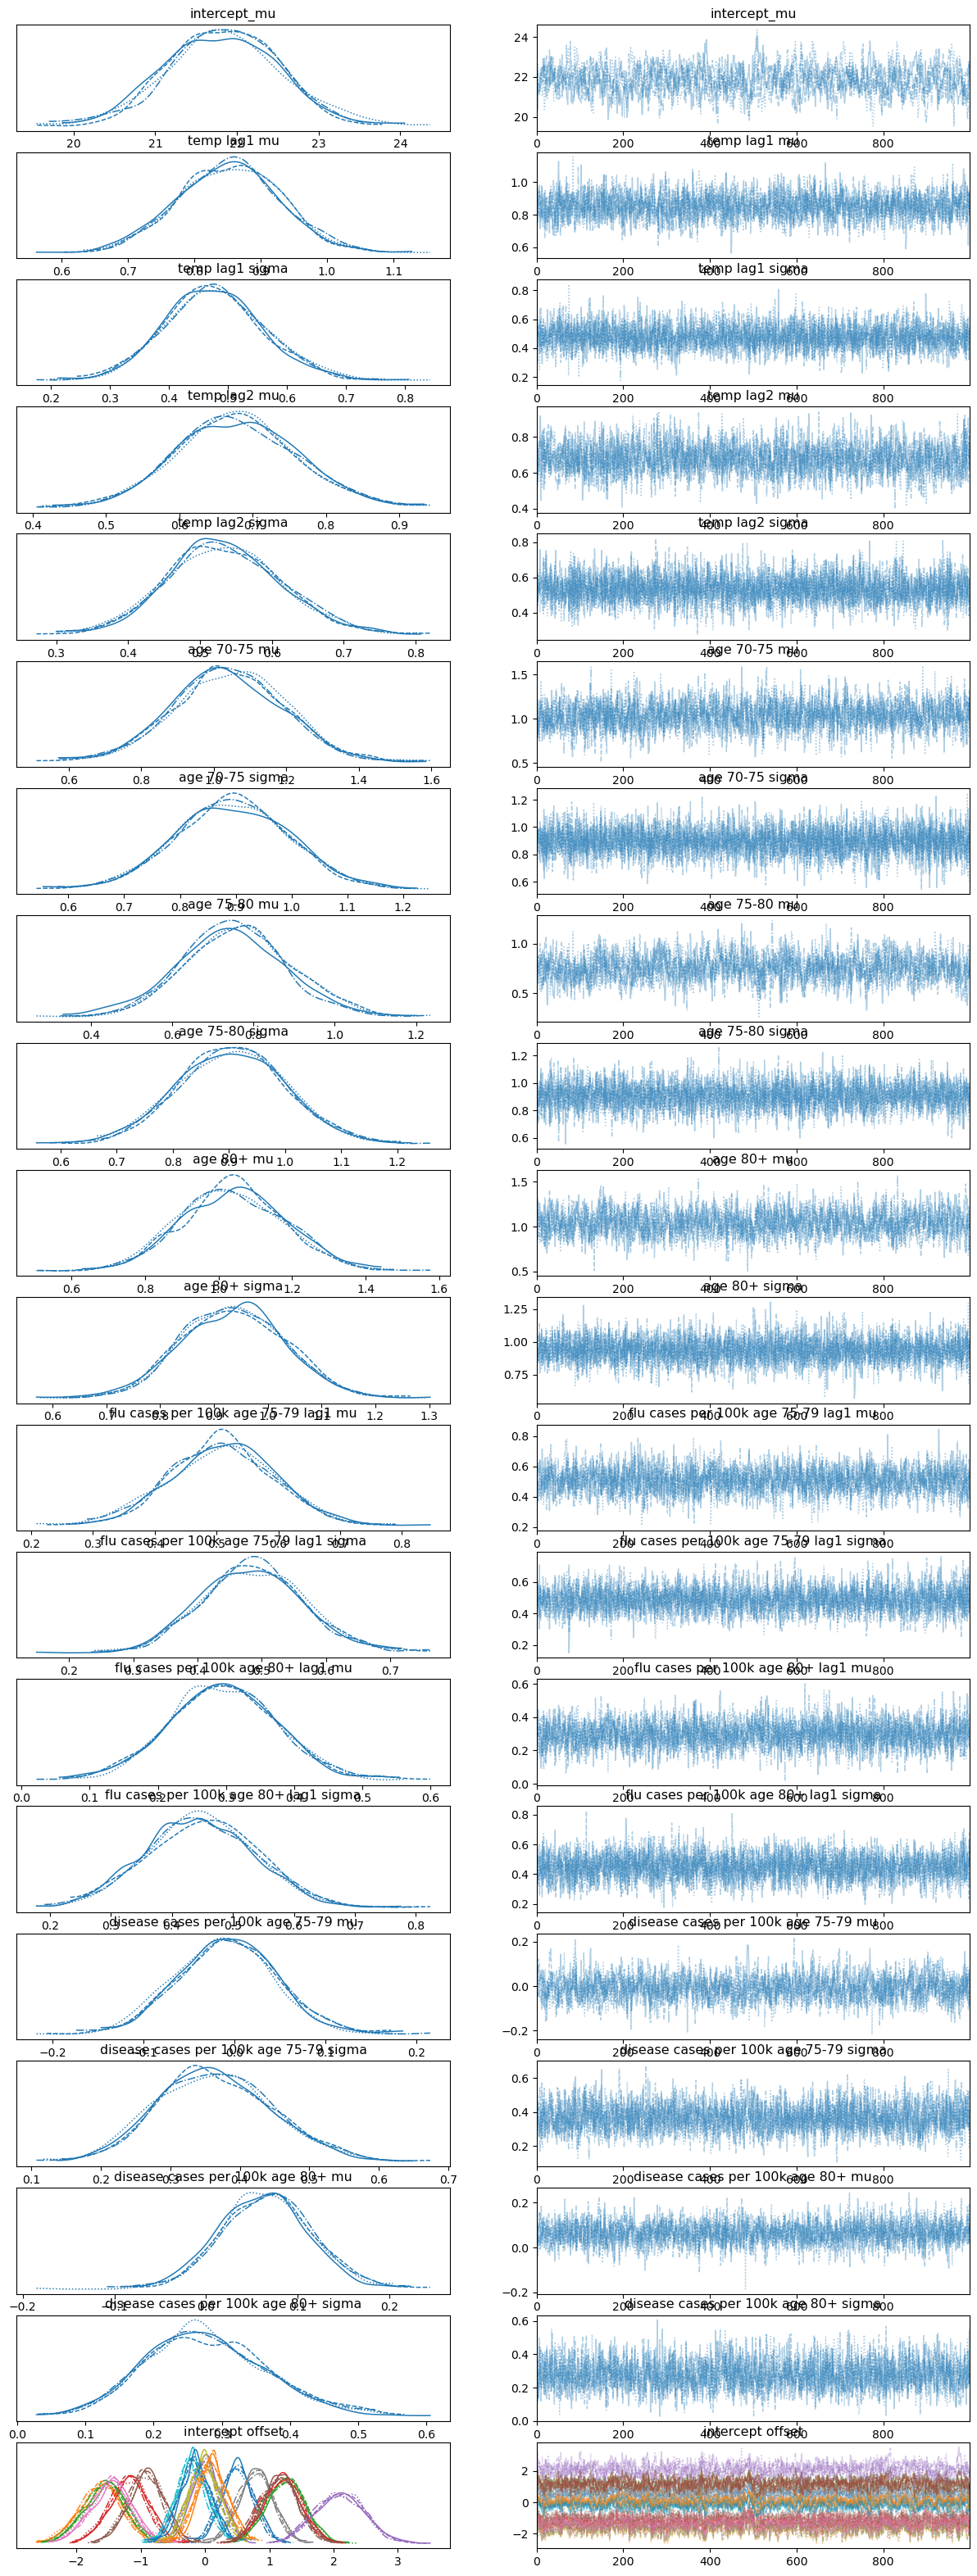

In [106]:
az.plot_trace(idata, var_names=["~mu"], figsize=(15, 40));

In [107]:
#| code-fold: show

with train_model:
    idata.extend(pm.sample_posterior_predictive(idata, random_seed=1))

In [109]:
pred_model = create_model(pre_df, post_df, infer_post=True)
state_idxs_, states_ = pd.factorize(post_df["state"])

with pred_model:

    pm.set_data({
        "time": post_df["t"].to_numpy(),
        "month": post_df["month"].to_numpy(),
        "state_idx": state_idxs_,
        "mean temp": post_df["mean_temp_st"].to_numpy(),
        "temp lag1": post_df["min_lt0_lag1"].to_numpy(),
        "temp lag2": post_df["min_lt0_lag2"].to_numpy(),
        "age 70-75": post_df["pop_share_70_st"].to_numpy(),
        "age 75-80": post_df["pop_share_75_st"].to_numpy(),
        "age 80+": post_df["pop_share_80_st"].to_numpy(),
        "flu cases per 100k age 75-79 lag1": post_df["flu_cases_75_per100k_lag1_st"].to_numpy(),
        "flu cases per 100k age 80+ lag1": post_df["flu_cases_80_per100k_lag1_st"].to_numpy(),
        "disease cases per 100k age 75-79": post_df["disease_cases_75_per100k_st"].to_numpy(),
        "disease cases per 100k age 80+": post_df["disease_cases_80_per100k_st"].to_numpy(),
    })

    counterfactual = pm.sample_posterior_predictive(
        idata, var_names=["obs"], random_seed=1
    )

In [118]:
def get_state_idx(state):
    _, states = pd.factorize(df["state"])
    return states.to_list().index(state)

def get_hdi_df(preds, hdi_prob_low, hdi_prob_high):
    hdi_dfs = []
    for kind, prob in zip(["low", "high"], [hdi_prob_low, hdi_prob_high]):
        hdi_df = (az.hdi(preds, hdi_prob=prob)
                    .to_dataframe()
                    .reset_index()
                    .pivot_table(index="obs_id", columns="hdi", values="obs")
                    .reset_index()
                    .rename_axis(None, axis=1)
                    .rename(columns={
                        "lower": f"{kind}_lower",
                        "higher": f"{kind}_higher"
                    }))
        hdi_dfs.append(hdi_df)
    hdi_df = pd.merge(left=hdi_dfs[0], right=hdi_dfs[1])
    hdi_df["pred_mean"] = preds.mean(dim=["chain", "draw"])
    return hdi_df

def get_posterior_predictive(idata,
                             counterfactual,
                             state,
                             hdi_prob_low=0.5, 
                             hdi_prob_high=0.9):
    state_idx = get_state_idx(state)

    pre_pred = (idata.posterior_predictive
                     .obs
                     .isel(obs_id=idata.constant_data.state_idx == state_idx))
    pre_hdi_df = get_hdi_df(pre_pred, hdi_prob_low, hdi_prob_high)
    pre_cols = (pre_df.iloc[pre_hdi_df.obs_id.values]
                      .loc[:, ["population", "deaths_total", "deaths_per100k", "covid_deaths_per100k", "year", "week", "date"]]
                      .reset_index(drop=True))
    pre_hdi_df = pd.concat([pre_hdi_df, pre_cols], axis=1)

    post_pred = (counterfactual.posterior_predictive
                               .obs
                               .isel(obs_id=counterfactual.constant_data.state_idx == state_idx))
    post_hdi_df = get_hdi_df(post_pred, hdi_prob_low, hdi_prob_high)
    post_cols = (post_df.iloc[post_hdi_df.obs_id.values]
                        .loc[:, ["population", "deaths_total", "deaths_per100k", "covid_deaths_per100k", "year", "week", "date"]]
                        .reset_index(drop=True))
    post_hdi_df = pd.concat([post_hdi_df, post_cols], axis=1)

    return pd.concat([pre_hdi_df, post_hdi_df], axis=0)

In [143]:
def plot_posterior_predictive(idata, 
                              counterfactual, 
                              state,
                              years=[2018, 2019, 2020, 2021, 2022],
                              hdi_prob_low=0.5,
                              hdi_prob_high=0.9,
                              absolute=True,
                              response_measures=True,
                              dominant_voc=True):
    # Get full name of state
    state_name = abbr2name[state]
    # Load state map
    state_map = plt.imread(map_path/f"{state}.png")
    map_box = OffsetImage(state_map, zoom=.14)
    
    # Load data and select appropriate date range
    df = get_posterior_predictive(idata, counterfactual, state, hdi_prob_low, hdi_prob_high)
    first_date = df.date.max() - timedelta(days=365 * (len(years)-1))
    df = df.loc[df.date >= first_date]
    first_month = df.date.dt.month.iloc[0]
    first_year = df.date.dt.year.iloc[0]
    
    # Setup figure
    fig, ax = plt.subplots(figsize=(16, 8))
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)
    for spine in ["bottom", "left"]:
        ax.spines[spine].set_linewidth(1.5)
    # ax.plot(df.date, df.pred_mean, color="#7a0b04")
    ax.set_title(f"Counterfactual estimate and actual deaths since {first_month}/{first_year}", fontsize=15)
    ax.xaxis.set_minor_locator(mdates.MonthLocator((1, 4, 7, 10)))
    ax.xaxis.set_minor_formatter(mdates.DateFormatter("%b"))
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.tick_params(axis="x", which="both", rotation=45)
    ax.tick_params(axis="x", which="major", labelsize=11.5)
    ax.set_xlim([first_date + timedelta(days=10), df.date.max() + timedelta(days=235)])
    ax.tick_params(axis="y", which="major", labelsize=11)

    # Plot data
    if not absolute:
        ax.fill_between(df.date, df.high_lower, df.high_higher, color="#f0928b", label=f"{hdi_prob_high * 100:.0f}% CI")
        ax.fill_between(df.date, df.low_lower, df.low_higher, color="#d9746c", label=f"{hdi_prob_low * 100:.0f}% CI")
        ax.plot(df.date, df.deaths_per100k, lw="2", color="#404040", label="actual deaths")
        # ax.plot(df.date, df.pred_mean + df.covid_deaths_per100k, lw="2", color="blue", label="C19 deaths")

        ylim_min = df.deaths_per100k.min() - 2
        ylim_max = df.deaths_per100k.max() + 3
        ax.set_ylim((ylim_min, ylim_max))

        state_name = state_name if not "-" in state_name else "-\n".join(state_name.split("-"))
        xt = mdates.date2num(df.date.iloc[-1] + pd.Timedelta(days=110))
        ax.text(xt, ylim_min + 0.8 * (ylim_max - ylim_min), s=state_name, ha="center", fontsize=14)
        ab = AnnotationBbox(map_box, (xt, ylim_min + 0.65 * (ylim_max - ylim_min)), frameon=False, zorder=10)
        ax.add_artist(ab)

        ax.set_ylabel("weekly deaths per 100,000 people", fontsize=13, labelpad=5)
    else:
        mul = df.population / 100_000
        ax.fill_between(df.date, df.high_lower * mul, df.high_higher * mul, color="#f0928b", label=f"{hdi_prob_high * 100:.0f}% CI")
        ax.fill_between(df.date, df.low_lower * mul, df.low_higher * mul, color="#d9746c", label=f"{hdi_prob_low * 100:.0f}% CI")
        ax.plot(df.date, df.deaths_per100k * mul, lw="2", color="#404040", label="actual deaths")

        ylim_min = df.deaths_per100k.mul(mul).min() * 0.9
        ylim_max = df.deaths_per100k.mul(mul).max() * 1.1
        ax.set_ylim((ylim_min, ylim_max))

        state_name = state_name if not "-" in state_name else "-\n".join(state_name.split("-"))
        xt = mdates.date2num(df.date.iloc[-1] + pd.Timedelta(days=110))
        ax.text(xt, ylim_min + 0.8 * (ylim_max - ylim_min), s=state_name, ha="center", fontsize=14)
        ab = AnnotationBbox(map_box, (xt, ylim_min + 0.65 * (ylim_max - ylim_min)), frameon=False, zorder=10)
        ax.add_artist(ab)

        ax.set_ylabel("weekly deaths", fontsize=13, labelpad=5)

    # Plot response measures
    if response_measures:
        for start, end, level in [(pd.Timestamp(year=2020, month=3, day=9), pd.Timestamp(year=2020, month=5, day=5), 2),
                                  (pd.Timestamp(year=2020, month=11, day=2), pd.Timestamp(year=2020, month=12, day=8), 1),
                                  (pd.Timestamp(year=2020, month=12, day=9), pd.Timestamp(year=2021, month=5, day=31), 2),
                                  (pd.Timestamp(year=2021, month=11, day=24), pd.Timestamp(year=2022, month=3, day=19), 1)]:
            level2color = {
                2: "#d97914",
                1: "#fcdb44"
            }
            start = mdates.date2num(start)
            end = mdates.date2num(end)
            width = end - start
            if not absolute:
                anchor = (start, df.deaths_per100k.min() - 2)
                height = df.deaths_per100k.max() - df.deaths_per100k.min() + 2.25
            else:
                anchor = (start, ylim_min)
                height = (df.deaths_per100k.mul(mul).max() - df.deaths_per100k.mul(mul).min()) * 1.2

            rect = patches.Rectangle(xy=anchor, width=width, height=height, 
                                     color=level2color[level], hatch="//", 
                                     fill=None, lw=0, zorder=-1)
            ax.add_patch(rect)
    
    # Plot dominant variants
    if dominant_voc:
        if not absolute:
            ymax = df.deaths_per100k.max() + 1.25
            line_ymax = ymax - 0.25
            arrow_y = ymax
            text_y = ymax + 0.25
        else:
            ymax = ylim_max * 0.95
            line_ymax = ymax
            arrow_y = ymax * 1.0075
            text_y = ymax * 1.015

        for t, desc, in [(pd.Timestamp(year=2020, month=1, day=27), 
                        "First case detected\n in Germany")]:
            ax.vlines(t, ylim_min, line_ymax, color="black", lw=0.5, zorder=-1)
            ax.text(t, text_y * 0.99, s=desc, ha="center", fontsize=9)
        
        for t, desc in [(pd.Timestamp(year=2021, month=3, day=1), "Alpha"),
                        (pd.Timestamp(year=2021, month=6, day=20), "Delta"),
                        (pd.Timestamp(year=2021, month=12, day=20), "BA. 1"),
                        (pd.Timestamp(year=2022, month=3, day=1), "BA. 2"),
                        (pd.Timestamp(year=2022, month=6, day=10), "BA. 5")]:
            ax.vlines(t, ylim_min, line_ymax, color="black", lw=0.5, zorder=-1)
            width = mdates.date2num(t + pd.Timedelta(days=21)) - mdates.date2num(t)
            head_width = 0.2 if not absolute else ymax * 0.0075
            ax.arrow(t, arrow_y, 
                        dx=width, dy=0, 
                        head_width=head_width, 
                        head_length=width*0.3, 
                        lw=0.5,
                        color="black")
            ax.text(t, text_y, s=desc, ha="center", fontsize=9)

    
    # Plot legend
    ax.legend(facecolor="white", edgecolor="white");

We can now plot our counterfactual estimate against the actually recorded number of deaths again, but this time for individual states. Let's have a look at Bavaria, for instance:

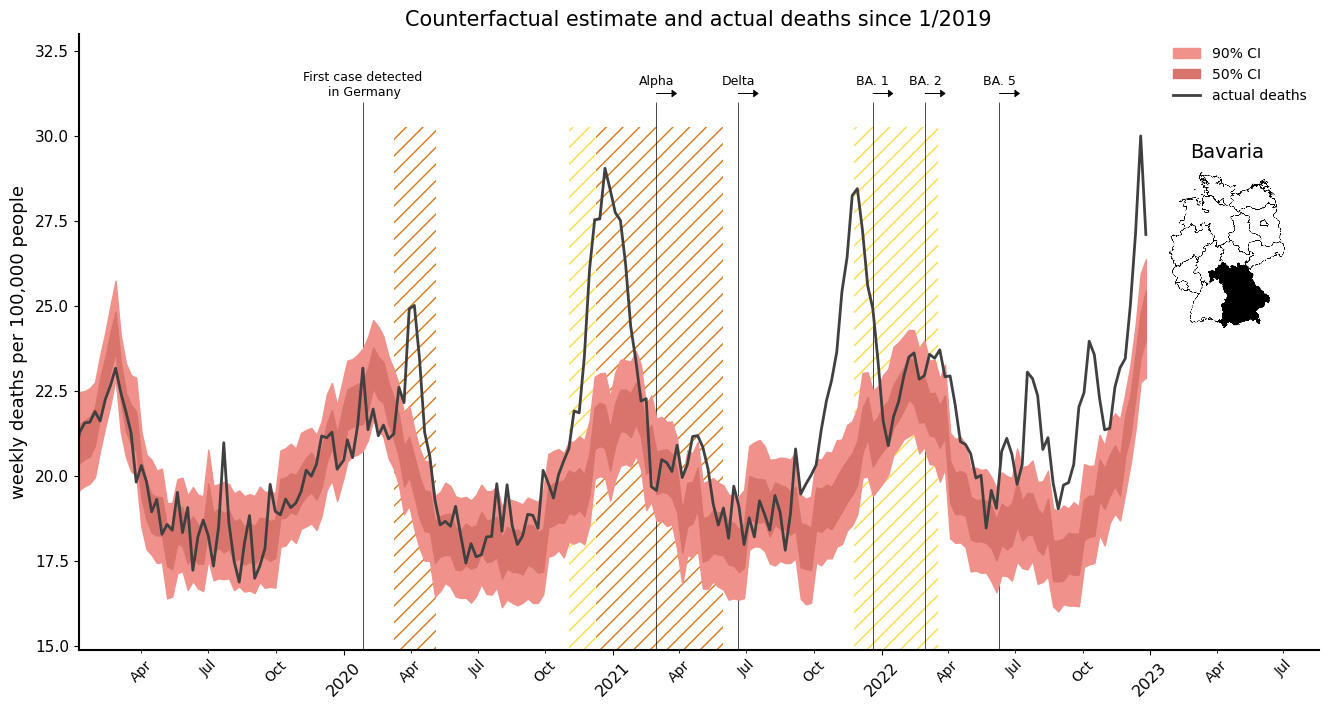

In [146]:
plot_posterior_predictive(idata, counterfactual, state="by", absolute=False)

In [132]:
def get_cf_hdi_df(preds, hdi_prob_low, hdi_prob_high):
    hdi_dfs = []
    for kind, prob in zip(["low", "high"], [hdi_prob_low, hdi_prob_high]):
        hdi_df = (az.hdi(preds, hdi_prob=prob)
                    .to_dataframe()
                    .reset_index()
                    .pivot_table(index="obs_id", columns="hdi", values="obs_id")
                    .reset_index()
                    .rename_axis(None, axis=1)
                    .rename(columns={
                        "lower": f"{kind}_lower",
                        "higher": f"{kind}_higher"
                    }))
        hdi_dfs.append(hdi_df)
    hdi_df = pd.merge(left=hdi_dfs[0], right=hdi_dfs[1])
    hdi_df["pred_mean"] = preds.mean(dim=["chain", "draw"])

    post_cols = (post_df.iloc[hdi_df.obs_id.values]
                        .loc[:, ["population", "deaths_total", "deaths_per100k", "covid_deaths_per100k", "year", "week", "date"]]
                        .reset_index(drop=True))
    hdi_df = pd.concat([hdi_df, post_cols], axis=1)

    return hdi_df

def get_excess_deaths(state):
    state_idx = get_state_idx(state)
    cf = (counterfactual.posterior_predictive
                        .obs
                        .isel(obs_id=counterfactual.constant_data.state_idx == state_idx))
    deaths = xr.DataArray(post_df[post_df.state == state]["deaths_per100k"].to_numpy(), dims=["obs_id"])
    excess_deaths = deaths - cf
    cum_excess = excess_deaths.cumsum(dim="obs_id")

    return excess_deaths.transpose(..., "obs_id"), cum_excess.transpose(..., "obs_id")

def plot_excess_deaths(state, 
                       hdi_prob_low=0.5, 
                       hdi_prob_high=0.9, 
                       absolute=True,
                       dominant_voc=True, 
                       response_measures=True):
    # Get full name of state
    state_name = abbr2name[state]
    state_name = state_name if not "-" in state_name else "-\n".join(state_name.split("-"))
    # Load state map
    state_map = plt.imread(map_path/f"{state}.png")
    map_box = OffsetImage(state_map, zoom=.14)

    excess_deaths, cumsum = get_excess_deaths(state)

    fig, ax = plt.subplots(2, 1, figsize=(15, 9), sharex=True)

    for i in range(2):
        ax[i].tick_params(axis="y", which="major", labelsize=10)
        for spine in ["top", "right"]:
            ax[i].spines[spine].set_visible(False)
        for spine in ["bottom", "left"]:
            ax[i].spines[spine].set_linewidth(1.2)
        if i == 0:
            ax[i].spines["bottom"].set_visible(False)
            ax[i].tick_params(axis="x", which="both", bottom=False)
        

    ax[0].set_title(f"Excess deaths since 01/20", fontsize=14)

    excess_df = get_cf_hdi_df(excess_deaths, hdi_prob_low, hdi_prob_high)

    xlim_min = pd.Timestamp(year=2019, month=12, day=30)
    xlim_max = excess_df.date.max() + timedelta(days=180)
    for i in range(2):
        ax[i].set_xlim((xlim_min, xlim_max))


    if not absolute:
        excess_ylim_min = excess_df.high_lower.min() * 1.3
        excess_ylim_max = excess_df.high_higher.max() * 1.3
        ax[0].fill_between(excess_df.date, excess_df.high_lower, excess_df.high_higher, color="#f0928b", alpha=0.75, label=f"{hdi_prob_high * 100:.0f}% CI")
        ax[0].fill_between(excess_df.date, excess_df.low_lower, excess_df.low_higher, color="#d9746c", alpha=0.75, label=f"{hdi_prob_low * 100:.0f}% CI")
        ax[0].plot(excess_df.date, excess_df.covid_deaths_per100k, lw=2.5, color="#44454a", label="official\nC19 deaths")
        ax[0].hlines(y=0, xmin=xlim_min, xmax=excess_df.date.max(), lw=1.5, ls="--", color="black")
        ax[0].set_ylabel("weekly excess deaths per 100,000 people", fontsize=11)
        xt = mdates.date2num(excess_df.date.iloc[-1] + pd.Timedelta(days=110))
        ax[0].text(xt, excess_ylim_min + 0.82 * (excess_ylim_max - excess_ylim_min), s=state_name, ha="center", fontsize=14)
        ab = AnnotationBbox(map_box, (xt, excess_ylim_min + 0.57 * (excess_ylim_max - excess_ylim_min)), frameon=False, zorder=10)
        ax[0].add_artist(ab)
    else: 
        mul = excess_df.population / 100_000
        excess_ylim_min = excess_df.high_lower.mul(mul).min() * 1.3
        excess_ylim_max = excess_df.high_higher.mul(mul).max() * 1.3
        ax[0].fill_between(excess_df.date, excess_df.high_lower.mul(mul), excess_df.high_higher.mul(mul), color="#f0928b", alpha=0.75, label=f"{hdi_prob_high * 100:.0f}% CI")
        ax[0].fill_between(excess_df.date, excess_df.low_lower.mul(mul), excess_df.low_higher.mul(mul), color="#d9746c", alpha=0.75, label=f"{hdi_prob_low * 100:.0f}% CI")
        ax[0].plot(excess_df.date, excess_df.covid_deaths_per100k.mul(mul), lw=2.5, color="#44454a", label="official\nC19 deaths")
        ax[0].hlines(y=0, xmin=xlim_min, xmax=excess_df.date.max(), lw=1.5, ls="--", color="black")
        ax[0].set_ylabel("weekly excess deaths", fontsize=11)
        xt = mdates.date2num(excess_df.date.iloc[-1] + pd.Timedelta(days=110))
        ax[0].text(xt, excess_ylim_min + 0.82 * (excess_ylim_max - excess_ylim_min), s=state_name, ha="center", fontsize=14)
        ab = AnnotationBbox(map_box, (xt, excess_ylim_min + 0.57 * (excess_ylim_max - excess_ylim_min)), frameon=False, zorder=10)
        ax[0].add_artist(ab)
    
    for y in ax[0].get_yticks()[1:-1]:
        ax[0].hlines(y=y, xmin=xlim_min, xmax=excess_df.date.max(), lw=0.5, color="#a1a1a1", zorder=-10)
    ax[0].legend(facecolor="white", edgecolor="white", loc="lower right")

    # Plot response measures
    if response_measures:
        for start, end, level in [(pd.Timestamp(year=2020, month=3, day=9), pd.Timestamp(year=2020, month=5, day=5), 2),
                                  (pd.Timestamp(year=2020, month=11, day=2), pd.Timestamp(year=2020, month=12, day=8), 1),
                                  (pd.Timestamp(year=2020, month=12, day=9), pd.Timestamp(year=2021, month=5, day=31), 2),
                                  (pd.Timestamp(year=2021, month=11, day=24), pd.Timestamp(year=2022, month=3, day=19), 1)]:
            level2color = {
                2: "#d97914",
                1: "#fcdb44"
            }
            start = mdates.date2num(start)
            end = mdates.date2num(end)
            anchor = (start, excess_ylim_min * 0.8)
            width = end - start
            height = (excess_ylim_max - excess_ylim_min) * 0.8

            rect = patches.Rectangle(xy=anchor, width=width, height=height, 
                                     color=level2color[level], hatch="//", 
                                     fill=None, lw=0, zorder=-1)
            ax[0].add_patch(rect)
    
    # Plot dominant variants
    if dominant_voc:
        for t, desc, in [(pd.Timestamp(year=2020, month=1, day=27), 
                         "First case detected\n in Germany")]:
            ax[0].vlines(t, excess_ylim_min * 0.8, excess_ylim_max * 0.8, color="black", lw=0.5, zorder=-1)
            ax[0].text(t + pd.Timedelta(days=20), excess_ylim_min * 1.1, s=desc, ha="center", fontsize=9)
            for t, desc in [(pd.Timestamp(year=2021, month=3, day=1), "Alpha"),
                        (pd.Timestamp(year=2021, month=6, day=20), "Delta"),
                        (pd.Timestamp(year=2021, month=12, day=20), "BA. 1"),
                        (pd.Timestamp(year=2022, month=3, day=1), "BA. 2"),
                        (pd.Timestamp(year=2022, month=6, day=10), "BA. 5")]:
                ax[0].vlines(t, excess_ylim_min * 0.8, excess_ylim_max * 0.8, color="black", lw=0.5, zorder=-1)
                width = mdates.date2num(t + pd.Timedelta(days=14)) - mdates.date2num(t)
                head_width = 0.5 if not absolute else excess_ylim_max * 0.02
                ax[0].arrow(t, excess_ylim_min * 0.85, 
                            dx=width, dy=0, 
                            head_width=head_width, 
                            head_length=width*0.3, 
                            lw=0.5,
                            color="black")
                ax[0].text(t, excess_ylim_min * 1, s=desc, ha="center", fontsize=9)

    cumsum_df = get_cf_hdi_df(cumsum, hdi_prob_low, hdi_prob_high)
    if not absolute:
        ax[1].fill_between(cumsum_df.date, cumsum_df.high_lower, cumsum_df.high_higher, color="#f0928b", alpha=0.75, label=f"{hdi_prob_high * 100:.0f}% CI")
        ax[1].fill_between(cumsum_df.date, cumsum_df.low_lower,cumsum_df.low_higher, color="#d9746c", alpha=0.75, label=f"{hdi_prob_low * 100:.0f}% CI")
        ax[1].plot(cumsum_df.date, cumsum_df.covid_deaths_per100k.cumsum(), lw=2.5, color="#44454a", label="cumulative\nC19 deaths")
        ax[1].hlines(y=0, xmin=xlim_min, xmax=excess_df.date.max(), lw=1.5, ls="--", color="black")
        ax[1].set_ylabel("cumulative excess deaths per 100,000 people", fontsize=11)
    else:
        mul = cumsum_df.population / 100_000
        ax[1].fill_between(cumsum_df.date, cumsum_df.high_lower.mul(mul), cumsum_df.high_higher.mul(mul), color="#f0928b", alpha=0.75, label=f"{hdi_prob_high * 100:.0f}% CI")
        ax[1].fill_between(cumsum_df.date, cumsum_df.low_lower.mul(mul),cumsum_df.low_higher.mul(mul), color="#d9746c", alpha=0.75, label=f"{hdi_prob_low * 100:.0f}% CI")
        ax[1].plot(cumsum_df.date, cumsum_df.covid_deaths_per100k.mul(mul).cumsum(), lw=2.5, color="#44454a", label="cumulative\nC19 deaths")
        ax[1].hlines(y=0, xmin=xlim_min, xmax=excess_df.date.max(), lw=1.5, ls="--", color="black")
        ax[1].set_ylabel("cumulative excess deaths", fontsize=11)

    for y in ax[1].get_yticks()[1:-1]:
        ax[1].hlines(y=y, xmin=xlim_min, xmax=excess_df.date.max(), lw=0.5, color="#a1a1a1", zorder=-10)

    ax[1].xaxis.set_minor_locator(mdates.MonthLocator(range(1, 13)))
    ax[1].xaxis.set_minor_formatter(mdates.DateFormatter("%b"))
    ax[1].xaxis.set_major_locator(mdates.YearLocator())
    ax[1].tick_params(axis="x", which="both", rotation=45)
    ax[1].tick_params(axis="x", which="minor", labelsize=9.5)
    ax[1].tick_params(axis="x", which="major", labelsize=11.5)
    ax[1].set_xlim([pd.Timestamp(year=2019, month=12, day=1) + timedelta(days=10), df.date.max() + timedelta(days=200)])

    plt.subplots_adjust(hspace=0.1);

What is probably more interesting, though, is looking at *excess* mortality specifically. This time, I also included the cumulative estimated excess deaths over the course of the pandemic in the bottom part of the plot. Note that the scales of the y-axis are not the same for different states!

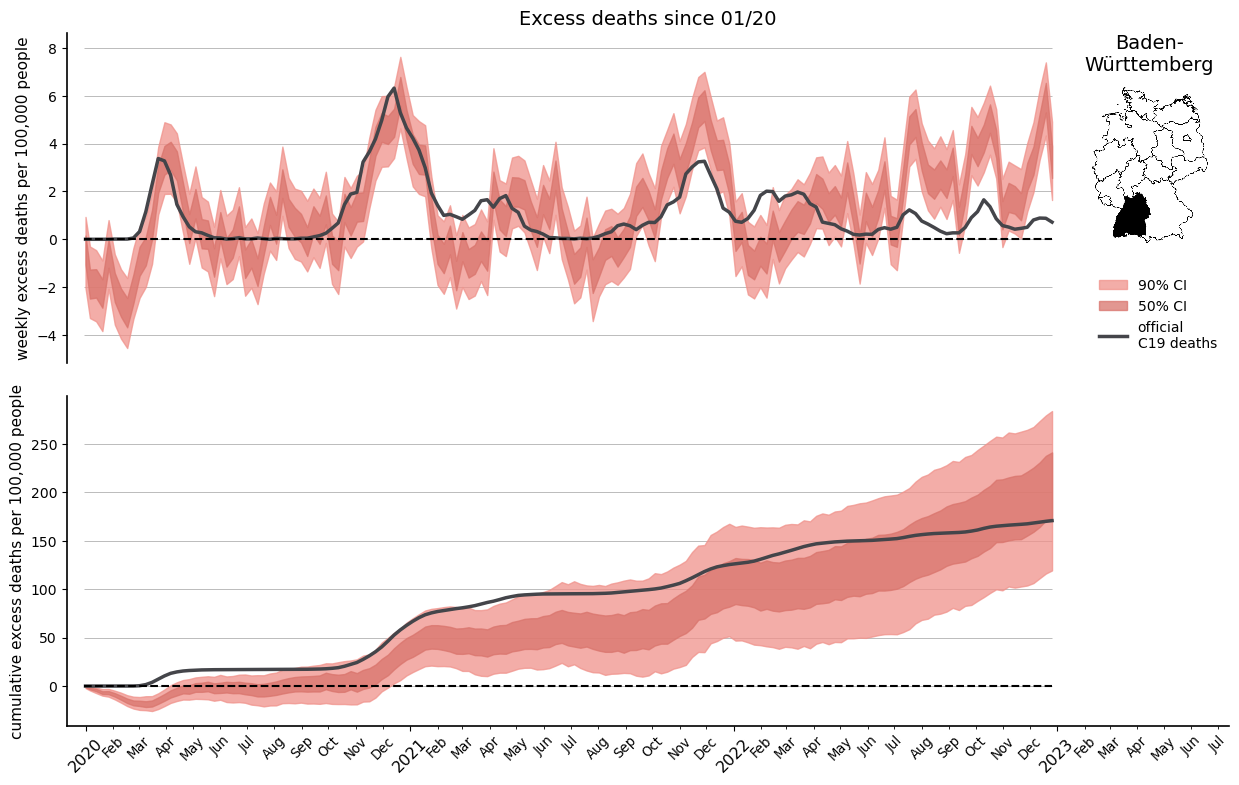

In [141]:
plot_excess_deaths("bw", absolute=False, dominant_voc=False, response_measures=False)

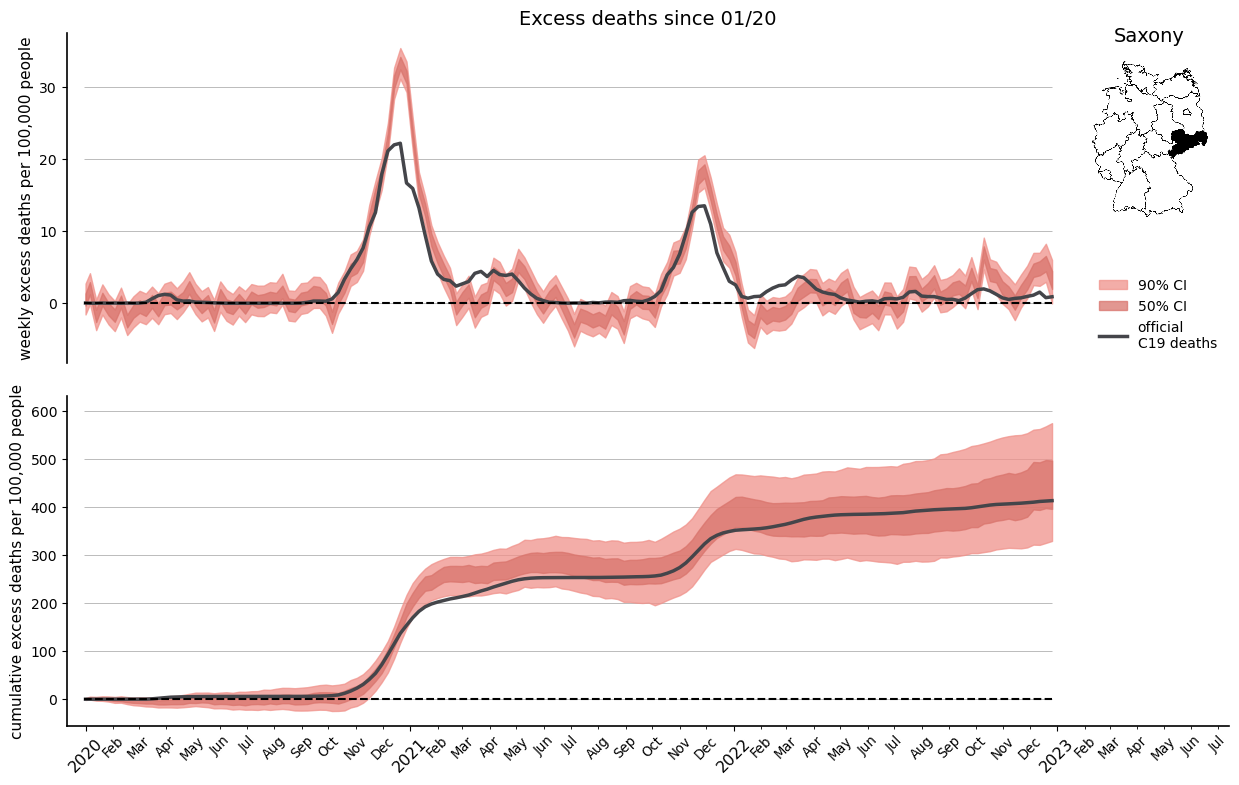

In [142]:
plot_excess_deaths("sn", absolute=False, dominant_voc=False, response_measures=False)

Finally, we can put the model's estimates in a pandas DataFrame to get a better summary. As we can see, there are marked differences between the German states:

In [160]:
def get_states_excess(hdi_prob_low=0.5, hdi_prob_high=0.9):
    states = []
    excess = []
    for state in post_df.state.unique():
        _, cumsum = get_excess_deaths(state)
        cumsum_df = get_cf_hdi_df(cumsum, hdi_prob_low, hdi_prob_high)
        mul = cumsum_df.population / 100_000
        states.append(state)
        excess.append(cumsum_df.pred_mean.iloc[-1])
    df = pd.DataFrame({
        "state": states,
        "excess_deaths_per100k": excess,
    })
    return (
        df.assign(state=lambda df_: df_.state.map(abbr2name))
          .astype({"excess_deaths_per100k": "int"})
          .sort_values(by="excess_deaths_per100k")
          .reset_index(drop=True)
    )

In [161]:
get_states_excess()

state  excess_deaths_per100k
0                          Berlin                    149
1               Baden-Württemberg                    204
2   Mecklenburg-Western Pomerania                    217
3                         Hamburg                    227
4              Schleswig-Holstein                    234
5            Rhineland-Palatinate                    256
6                         Bavaria                    279
7                           Hesse                    297
8                    Lower Saxony                    305
9                          Bremen                    327
10         North Rhine-Westphalia                    357
11                       Saarland                    375
12                    Brandenburg                    436
13                      Thuringia                    437
14                         Saxony                    447
15                  Saxony-Anhalt                    502